# Hardness properties of a polycrystal
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the hardness map of a polycrystal.

The network is trained to predict the load-depth curves of nanoindented grains in steel. 

After training, the network's prediction ability is illustrated by comparing its output to the true hardness of the material.

# Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [165]:
install_graph_nets_library = "No"  #param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


# load libraries

In [166]:
import configparser
confParser = configparser.ConfigParser()
confParser.read('config_irradiated.ini')
confParser.sections()


['Parameters',
 'flags',
 'gnn library path',
 'python libarary path',
 'test data files']

In [196]:
import sys
sys.path.append(confParser['gnn library path']['gnnLibDir'])
sys.path.append(confParser['python libarary path']['pyLibDir'])
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import utility as utl
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
import os
import traceback
import imp
imp.reload(utl)
from scipy.spatial import KDTree
from scipy.interpolate import Rbf
import time
from scipy.stats import zscore

import functools
from typing import Any, Dict, Text,Tuple,Optional


import enum
import pickle
#from absl import logging
import numpy as np


import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

import sonnet as snt

from graph_nets import graphs
from graph_nets import modules as gn_modules
from graph_nets import utils_tf
from gnn_graphnet_model import *
from graph_nets import utils_np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats

SEED =4441666
np.random.seed(SEED)
#tf.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# utility funcs

In [168]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x].flatten(),self.neigh_mat))]
        assert np.all(list(map(lambda x:np.any(x>0.0),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[x>0.0],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: x.mean(), h_list))
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        
        
def load_test_data(test_data_file_path,test_data_file_path2nd):
    # read the csv file and return the text line list.
    test_data_row_list = pd.read_csv(test_data_file_path,sep=' ')
    test_data_row_list2nd = pd.read_csv(test_data_file_path2nd,sep=' ')
    print('open and load data from test_data.csv complete.')
    return test_data_row_list, test_data_row_list2nd


def FilterDataFrame(test_data_grains,key='id',val=[1,2,3],out='index'):
    tmp = pd.DataFrame(np.c_[np.arange(test_data_grains.shape[0]),test_data_grains],columns=[out]+list(test_data_grains.keys()))
    return np.c_[tmp.set_index(key,drop=True,append=False).loc[val][out]].flatten().astype(int)

    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               predictors,
                attributes,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
                                         test_data_file_path2nd
                                        )

    positions = np.c_[test_data.apply(zscore)[attributes]].tolist()
    edges = np.c_[test_data2nd[['misOrientationAngle(deg)','boundaryLength(micron)']]].tolist()
    

    grain_i_indices = FilterDataFrame(test_data_grains,key='#grainID',val=test_data_grains2nd['#grain_i_ID'],out='index')
    grain_j_indices = FilterDataFrame(test_data_grains,key='#grainID',val=test_data_grains2nd['grain_j_ID'],out='index')

    receivers = list(grain_j_indices)#test_data2nd['grain_j_ID'].astype(int))
    senders = list(grain_i_indices) #test_data2nd['#grain_i_ID'].astype(int)) 
    
    #--- target vector
    target = None #list(map(lambda x:list(x),predictors))
    weight = list(np.ones(test_data.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op




# Creating graphs

## target data

### parse load depth curves

In [169]:
class LoadDepth:
    
    def __init__(self,loadLabels):
        self.loadLabels = loadLabels
        
    def inputFiles(self,loadLabel):
        return os.listdir('%s/%s'%(confParser['test data files']['load_depth_path'],self.loadLabels[loadLabel]))

    def indentLabels(self,loadLabel): 
        return list(map(lambda x:self.GetIndentLabel(x),self.inputFiles(loadLabel)))

    def GetIndentLabel(self,strr):
        indxi=strr.find('x')+2
        indxf=indxi+2 #strr.find('5000')
        return strr[indxi:indxf]
    
    def loadTimeSeries(self,confParser,loadLabel):
        return list(map(lambda x:pd.read_csv('%s/%s/%s'%(confParser['test data files']['load_depth_path'],self.loadLabels[loadLabel],x),
                 sep='\t',index_col=False,names=['Time','Depth','Force']),self.inputFiles(loadLabel)))

    def GetGrainId(self,indent,indentLabels,loadID,index):
        indentLabel = indentLabels[index]
        filtr = np.all([indent['label']==int(indentLabel),indent['#loadID']==loadID],axis=0)
        if not np.any(filtr):
            'warning: indenter %s not on the plane!'%indentLabel
            return indentLabel, np.nan
        grainID = indent[filtr]['grainID'].iloc[0]
        return indentLabel, grainID

    def Write(self,loadID,confParser,path_indented,path):
        loadTimeSeries = self.loadTimeSeries(confParser,loadID)
        indentLabels = self.indentLabels(loadID)
        indent = pd.read_csv('%s/indenter_grainID.txt'%path_indented,sep=' ')
        for index in range(len(loadTimeSeries)): #--- file index
            ld = loadTimeSeries[ index ] #--- file id
            indentLabel, grainID = self.GetGrainId(indent,indentLabels,loadID,index)
            print('indent label:%s, grain id:%s'%(indentLabel,grainID))
            #
            filtr = np.all([ld.Time>0],axis=0)
            np.savetxt('%s/loadDepth_GrainID_%s_LoadID%s_IndentLabel_%s.txt'%(path,grainID,loadID,int(indentLabel)),
                       np.c_[ld.Depth[filtr], ld.Force[filtr]],
                       header='Depth(nm)\tForce(mN)',
                       fmt='%4.3e\t%4.3e')

os.system('mkdir -p %s/ldGrainID'%confParser['test data files']['load_depth_path'])
load_depth = LoadDepth(
       {0:'10 mN',
        1:'7 mN',
        2:'5 mN',
        3:'4.5 mN',
        4:'4 mN',
        5:'3.5 mN',
        6:'3 mN',
        7:'2.5 mN',
        8:'2 mN',
        9:'1.75 mN',
        10:'1.5 mN',
        11:'1.25 mN'}
        )
# for load_id in load_depth.loadLabels:
#     print('load_id=',load_id)
# #    load_depth.inputFiles(0)
# #    load_depth.indentLabels(0)
#     #--- read input file
# #    load_depth.loadTimeSeries(confParser,0)
      #--- write on disc
#     load_depth.Write(load_id,
#                      confParser,
#                      confParser['test data files']['ebsd_path'], #--- indented grain ids
#                      confParser['test data files']['load_depth_path']+'/ldGrainID' #--- output
#                     )


In [170]:
class Finder():
    '''
    return a list of files in a directory
    '''
    def __init__(self,path_ld):
        self.files = os.listdir(path_ld)

    def Get(self,file_index):
        return self.files[file_index]
    
class TestData:
    '''
    return the feature matrix
    '''
    ld_curve = {}
    load = {}
    
    def __init__(self,path_ld,path_gb,verbose=False):
        self.path_ld = path_ld #--- ld data
        self.path_gb = path_gb #--- grain properties
        self.verbose = verbose

    def is_included(self,xlo,xhi):
        '''
        return bool: timeseries includes the range (xlo,xhi) 
        '''
        return self.data[:,0].min() <= xlo and self.data[:,0].max() >=  xhi   
            
    def Parse(self):
        if self.verbose:
            print('parsing %s'%(self.path_ld))
        self.data    = np.loadtxt( self.path_ld ) #--- load curve
        self.grains  = pd.read_csv(self.path_gb ,sep=' ')
        
    def Interp(self,bins):
        '''
        interpolate on the structured grid bins
        '''
#        self.xsum = np.interp(bins, self.data[:,0], self.data[:,1], left=None, right=None, period=None)
#        self.edges = bins
        
        self.xsum = self.Rbf(self.data[:,1],len(bins))
        self.edges = self.Rbf(self.data[:,0],len(bins))
        
    def Rbf(self,data,nbins):
        x = np.linspace(0, 1, data.shape[0])
        d = data 
        rbfi = Rbf(x, d)
        xi = np.linspace(0, 1, nbins)
        return rbfi(xi)
            
    def GetGrainIndex(self):
        '''
        return grain index and id 
        '''
        GetGrainID = lambda x:x[x.find('ID_')+3:x.find('_LoadID')]
#         pdb.set_trace()
        GrainID = GetGrainID(self.path_ld)
        filtr = self.grains['#grainID']==float(GrainID)
        assert np.any(filtr), 'grainID %s not exist!'%GrainID
        return self.grains[filtr].index[0]

    def Scale(self):
        '''
        return scaled data 
        '''
        self.data[:,0] /= np.max(self.data[:,1]) #--- scale by fmax
        self.data[:,1] /= np.max(self.data[:,1])
        
    @staticmethod
    def ReplaceNanByMean(forces):
        mean_force_array = np.mean(forces[~np.any(np.isnan(forces),axis=1)],axis=0) #--- replace missing data by the average
        isnan = np.any(np.isnan(forces),axis=1)
        
        for grain_indx in range(len(forces)):
            if isnan[grain_indx]:
                forces[grain_indx] = np.copy(mean_force_array)


    @staticmethod
    def Append(GrainIndex,disp,load):
        '''
        append stress timeseries
        '''
        TestData.ld_curve.setdefault(GrainIndex,[]).append(disp.copy()) #--- repetative
        TestData.load.setdefault(GrainIndex,[]).append(load.copy()) #--- repetative
        
    
    @staticmethod
    def BuildFeature(sdict,ngrains_total,n_ld):
    #--- build feature matrix
        keys=list(sdict.keys()) #--- indented grains
        mat = np.c_[list(map(lambda x:np.mean(np.c_[sdict[x]],axis=0),keys))] #--- matrix
#         print(mat.shape)
        df = pd.DataFrame(np.c_[keys,mat]) #--- data frame
        df.sort_values(0,inplace=True)
#         pdb.set_trace()
        #--- non-indented grains: inser nans
    #    
        ngrains_indented = df.shape[0]
    #    n_ld = np.arange(xlo,xhi,dx).shape[0]
        ngrains = ngrains_total - ngrains_indented
        mat_nan = np.ones(ngrains*n_ld).reshape((ngrains,n_ld))*np.nan
        #
#        keys_nonindented = np.arange(ngrains_total)-keys
        keys_nonindented = set(np.arange(ngrains_total))-set(keys)
        df_nonindent = pd.DataFrame(np.c_[list(keys_nonindented),mat_nan])
        #--- combine
        mat_new = np.concatenate([df,df_nonindent],axis=0)
        df = pd.DataFrame(np.c_[mat_new]).sort_values(0,inplace=False)
    #--- row number
#        ids=list(range(ngrains_total))
#        list(map(lambda x:ids.remove(x),keys))
#        keys = keys + ids

#        df = pd.DataFrame(np.c_[keys,mat_new])
        return np.c_[df.drop(columns=[0])]

In [171]:
def main():
    !mkdir png
    symbols=utl.Symbols()

    finder=Finder(confParser['test data files']['load_depth_path']+'/ldGrainID')
    display(finder.Get(0))

    #--- parse load curve
    test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path']+'/ldGrainID',finder.Get(1)),
                         path_gb=confParser['test data files']['test_data_file_path'],
                        )

    test_data.Parse()
    #test_data.Scale()
    GrainIndex = test_data.GetGrainIndex() #--- could be a nan!

    if not eval(confParser['flags']['remote_machine']):
        ax=utl.PltErr(test_data.data[:,0],test_data.data[:,1],
        #                xlim=(0,20),ylim=(0,0.2),
                       attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
                      Plot=False,
                       )
        test_data.Interp(bins=np.arange(test_data.data[:,0].min(),test_data.data.max(),0.1))
        utl.PltErr(test_data.edges,test_data.xsum,
            #                xlim=(0,20),ylim=(0,0.2),
                           attrs={'fmt':'-.r'},
                            ax=ax,
                           xstr='depth(nm)',
                           ystr='load(mN)',
            #               attrs=symbols.GetAttrs(fmt='-.r'),
                           title='png/loadDepth.png'

                            )
    
main()

mkdir: cannot create directory ‘png’: File exists


'loadDepth_GrainID_586_LoadID8_IndentLabel_7.txt'

AssertionError: grainID 704 not exist!

### multiple grains

In [ ]:
def GetDuplicateGrains():
    s=np.array(list(map(lambda x:len(TestData.ld_curve[x]),TestData.ld_curve.keys())))
    mask = s>1
    print('grains with more than one indentation data: ',np.array(list(TestData.ld_curve.keys()))[mask].shape)

def main():

    print('parse load depth curves ...')

    test_data_file_path = confParser['test data files']['test_data_file_path']
    test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
    test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    ngrains = test_data_grains.shape[0]

    ax  = utl.PltErr(None,None,Plot=False)

    #--- prescribed range for displacements 
    (xlo,xhi,dx)=(0.0,1.0,0.01)

    #--- loop over indented grains
    TestData.ld_curve = {}
    TestData.load = {}
    count_indented = 0
    for fp,count in zip(finder.files,range(len(finder.files))):
        test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path']+'/ldGrainID',fp),
                         path_gb=confParser['test data files']['test_data_file_path'],
                         verbose=False,
                        )
        test_data.Parse()
    #    test_data.Scale() #--- scale features
    #    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
    #        continue
        test_data.Interp(bins=np.arange(xlo,xhi,dx)) #--- interpolate
        try:
            GrainIndex = test_data.GetGrainIndex() #--- could be a nan!
        except:
            print('no GrainIndex for ',fp)
            continue

        if np.any(np.isnan(test_data.data[:,1])):
                print('nan in displacements: ',fp)

        #--- plot
        if not eval(confParser['flags']['remote_machine']):
            utl.PltErr(test_data.data[:,0],test_data.data[:,1],
                        attrs=symbols.GetAttrs(count=count%7),
                       ax=ax,Plot=False,
        #               xlim=(0,100),#xhi),# ylim=(0,6),
                      )
        TestData.Append(GrainIndex,test_data.edges,test_data.xsum) #--- assemble feature matrix: append displacements

        count_indented += 1
    print('# of indentation exp. is ',count_indented)

    GetDuplicateGrains()
    #--- predictors are the displacements
    predictors = TestData.BuildFeature(TestData.ld_curve, 
                                       ngrains,
                                       np.arange(xlo,xhi,dx).shape[0]
                                      )

    #---- forces
    forces = TestData.BuildFeature(TestData.load, 
                                       ngrains,
                                       np.arange(xlo,xhi,dx).shape[0]
                                      )
    TestData.ReplaceNanByMean(forces)

    print('# of indented grains: ',(~np.any(np.isnan(predictors),axis=1)).sum())

#main()

In [ ]:
# filtr = test_data_grains.subBoundaryLength > 0
# test_data_grains[filtr]

In [ ]:
# plt.xscale('log')
# plt.yscale('log')
# plt.scatter(test_data_grains['diameter'],test_data_grains['area'])

In [ ]:
# filtr = test_data_grains.diameter > 1.0
# hist,bin_edges,err = utl.GetPDF(test_data_grains.diameter[filtr],linscale=False,n_per_decade=8) 
# #hist,bin_edges,err = utl.GetPDF(test_data_grains.diameter[filtr],linscale=True,n_per_decade=16) 
# utl.PltErr(bin_edges,hist,yerr=err,
#           xscale='log',
#            yscale='log'
#           )

In [ ]:
#test_data_grains.Phi.mean(),test_data_grains.Phi.std()

### missing data

In [ ]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index,verbose=False):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()
        self.verbose = verbose

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        if self.verbose:
            print('neigh_mat.shape:',self.neigh_mat.shape)
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x],self.neigh_mat))]
        if self.verbose:
            print('h_mat.shape:',h_mat.shape)
        assert np.all(list(map(lambda x:np.any(~np.isnan(x)),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[np.all(~np.isnan(x),axis=1)],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: np.mean(x,axis=0), h_list))
        if self.verbose:
            print('h_mean.shape:',h_mean[0].shape)
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        

# interp0 = AddMissing(np.c_[test_data_grains[['x','y']]],
#                      predictors,#np.c_[df.drop(columns=[0])],
#                      np.all(np.isnan(predictors),axis=1),
#                      verbose=True,
#                            )

# interp0.kdTree(64) #--- nearest neighbors
# interp0.interpolate()
# predictors = interp0.val.shape

## build graph

### train-test split

In [ ]:
class train_test_split:
    '''
    Split arrays or matrices into random train and test subsets.
    '''
    def __init__(self,mask,
                 random_state=128,
                test_size=.3, train_size=.7):
        self.mask = mask
        self.random_state = random_state
        self.test_size=test_size
        self.train_size=train_size
        
    def train_test_split(self):
        '''
        random train-test split
        '''
        n=self.mask.shape[0]
        indented_indices = np.arange(n)[self.mask]
        n_indented = indented_indices.shape[0]
        np.random.seed(self.random_state)
        np.random.shuffle(indented_indices)
        #
        m=int(self.test_size*n_indented)
        test_set_indices = indented_indices[:m] #--- test set indices
        test_set=np.zeros(n,dtype=bool)
        test_set[test_set_indices]=True #--- assign True to test set oindices

        #
        m=int(self.train_size*n_indented)
        train_set_indices=indented_indices[n_indented-m:n_indented]
        train_set=np.zeros(n,dtype=bool)
        train_set[train_set_indices]=True #--- assign True to test set oindices

#        return train_set, test_set
        self.train_mask = train_set
        self.test_mask = test_set
    
    def train_test_split_structured(self,xy):
        '''
        structured split
        '''
        x=xy[:,0]
        y=xy[:,1]
        xlo, xhi = x.min(), x.max()
        ylo, yhi = y.min(), y.max()
        x_copy = np.array(x.copy() - xlo)
        y_copy = np.array(y.copy() - ylo)

        self.train_mask = np.all([x_copy < self.train_size * (xhi-xlo), self.mask],axis=0)
        self.test_mask = np.all([~self.train_mask, self.mask],axis=0)
    
    def train_test_split_cv(self,cv=3):
        '''
        Split arrays or matrices into *random* train and test subsets for cross validation.
        '''
        assert cv > 1, '# of partitions must be greater than 2'
        n=self.mask.shape[0]
        indented_indices = np.arange(n)[self.mask]
        n_indented = indented_indices.shape[0]
        np.random.seed(self.random_state)
        np.random.shuffle(indented_indices)
        m=int(n_indented/cv)
        test_set = {}
        for i in range(cv-1):
            test_set[i] = indented_indices[i*m:(i+1)*m] #--- test set indices
        test_set[i+1] = indented_indices[(i+1)*m:n_indented]
        assert n_indented == np.sum(list(map(lambda x:test_set[x].shape[0],test_set.keys())))
        #
        mask_dic = {}
        for i in range(cv):
            tmp_test=np.zeros(n,dtype=bool)
            tmp_test[test_set[i]]=True #--- assign True to test set oindices
            tmp_train = np.all([self.mask,~tmp_test],axis=0)
            assert not np.any(np.all([tmp_train,tmp_test],axis=0))
            mask_dic[i]={}
            mask_dic[i]['test'] = np.copy(tmp_test)
            mask_dic[i]['train'] = np.copy(tmp_train)

        self.mask_dic = mask_dic
    
    def train_test_split_cv_structured(self,xy,cv):
        '''
        Split arrays or matrices into *structured* train and test subsets for cross validation.
        '''
        m=cv[0]
        n=cv[1]
        x=xy[:,0]
        y=xy[:,1]
        xlo, xhi = x.min()-1e-6, x.max()+1e-6
        assert xhi > xlo
        ylo, yhi = y.min()-1e-6, y.max()+1e-6
        assert yhi > ylo
        x_copy = np.array(x.copy() - xlo)
        y_copy = np.array(y.copy() - ylo)
        lx = xhi-xlo
        ly = yhi-ylo
        #dy = ly / m
        #dx = lx / n
        df=pd.DataFrame(np.c_[list(map(int,m*y_copy / ly)),list(map(int,n*x_copy / lx))],columns=['row','col'])
        groups=df.groupby(by=['row','col']).groups

        mask_dic={}
        for igroup, count in zip(groups.keys(),range(m*n)):
            mask_dic[count]={}
            tmp = np.zeros(x.shape[0],dtype=bool)
            true_indices = groups[ igroup ]
            tmp[true_indices] = True
            tmp = np.all([tmp, self.mask],axis=0)
            mask_dic[count]['test'] = np.copy(tmp)
            mask_dic[count]['train'] = np.all([~tmp, self.mask],axis=0)
        #    mask_dic[count]['train'] = np.copy(tmp_train)
        self.mask_dic = mask_dic
    
    def Plot(self,test_data_grains,train_mask,test_mask):
        ax=utl.PltErr(test_data_grains[train_mask]['x'],test_data_grains[train_mask]['y'],
                  attrs={'fmt':'.'},
                 Plot=False
                 )

        utl.PltErr(test_data_grains[test_mask]['x'],test_data_grains[test_mask]['y'],
                      attrs={'fmt':'.','color':'red'},
                   ax=ax
                     )




In [ ]:
def main():
    print('test/train split ...')

    mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains
    #
    tsp = train_test_split(mask,
                     random_state=eval(confParser['Parameters']['seed']),
                    test_size=.3, train_size=.7)

    #--- train-test split (random)
    print('train-test split (random)')
    tsp.train_test_split()
    if not eval(confParser['flags']['remote_machine']):
        tsp.Plot(test_data_grains,
                 tsp.train_mask,
                 tsp.test_mask)

    #--- cross validate
    print('cv (random)')
    tsp.train_test_split_cv(eval(confParser['Parameters']['n_cross_val']))
    if not eval(confParser['flags']['remote_machine']):
        list(map(lambda x:tsp.Plot(test_data_grains,
                               tsp.mask_dic[x]['train'],
                               tsp.mask_dic[x]['test']),tsp.mask_dic.keys()))

    #--- train-test split (structured)
    print('train-test split (structured)')
    tsp.train_test_split_structured(np.c_[test_data_grains[['x','y']]])
    if not eval(confParser['flags']['remote_machine']):
        tsp.Plot(test_data_grains,
                 tsp.train_mask,
                 tsp.test_mask)

    #--- cross validate
    print('cv (structured)')
    n_cv = eval(confParser['Parameters']['n_cross_val'])
    tsp.train_test_split_cv_structured(np.c_[test_data_grains[['x','y']]],
                                                         (int(n_cv**.5),int(n_cv**.5))
                                                         )
    if not eval(confParser['flags']['remote_machine']):
        list(map(lambda x:tsp.Plot(test_data_grains,
                                   tsp.mask_dic[x]['train'],
                                   tsp.mask_dic[x]['test']),tsp.mask_dic.keys()))
        
#main()

In [ ]:
def GetSubset(mask,fraction):
    n=mask.shape[0]
    indented_indices = np.arange(n)[mask]
    n_indented = indented_indices.shape[0]
    np.random.seed(128)
    np.random.shuffle(indented_indices)
    m=int(fraction*n_indented)
    test_set = indented_indices[:m] #--- test set indices
    #
    tmp_test=np.zeros(n,dtype=bool)
    tmp_test[test_set]=True #--- assign True to test set oindices
    return tmp_test



In [ ]:
def BadGrains(mask,slist):
    for i in slist:
        mask[i]=False
#BadGrains(train_mask,[0,21,43,50,83,86,100,109,112])
#BadGrains(test_mask, [0,21,43,50,83,86,100,109,112])

In [ ]:
confParser['Parameters']['attributes'].split()

### input graph

In [ ]:
def main():

    #tf.set_random_seed(1234)
    #tf.get_default_graph().finalize() # something everybody tends to forget


    pure_lab='' 
    data_split = None
    data_split_lab=''
    #


    #--- path for csv data files
    test_data_file_path=confParser['test data files']['test_data_file_path']
    test_data_file_path2nd=confParser['test data files']['test_data_file_path2nd']


    
    #--- graph structure  
    static_graph_tr,\
    target_nodes_np, weight_np = base_graph(test_data_file_path, 
                                            test_data_file_path2nd,
                                            None,
                                            confParser['Parameters']['attributes'].split(), #--- attributes
                                            logtrans=data_split)
    print(static_graph_tr.keys())
    for k in static_graph_tr.keys():
        try:
            print(k, static_graph_tr[k].shape)
        except AttributeError:
            print(k)

    #--- graph without edges
    # if eval(confParser['flags']['without_edges']): 
    # #     static_graph_tr.pop('edges')
    # #     static_graph_tr.pop('receivers')
    # #     static_graph_tr.pop('senders')
    #     static_graph_tr['edges']=[static_graph_tr['edges'][0]]
    #     static_graph_tr['receivers']=[static_graph_tr['receivers'][0]]
    #     static_graph_tr['senders']=[static_graph_tr['senders'][0]]

    input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
    graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
    #print(input_graph)
    print('nodes matrix shape:',np.array(static_graph_tr['nodes']).shape)
    if not eval(confParser['flags']['without_edges']): 
        print('edge matrix shape:',np.array(static_graph_tr['edges']).shape)
        
    return static_graph_tr

static_graph_tr = main()

## Visualize 
### euclidean space

In [ ]:
class interpolate:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_points):

        self.points    = cords
        self.query_points = query_points
        self.val = val.copy()

    def kdTree(self):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.query_points], k=1)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
        
    def interpolate(self):        
        return self.val[self.neigh_mat.flatten()]

### nodes and edges

In [ ]:
def get_cmap(n):
    colors = [(1,1,1)] + [(np.random.random(),np.random.random(),np.random.random()) for i in range(n-1)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=n)
    return new_map



open and load data from test_data.csv complete.


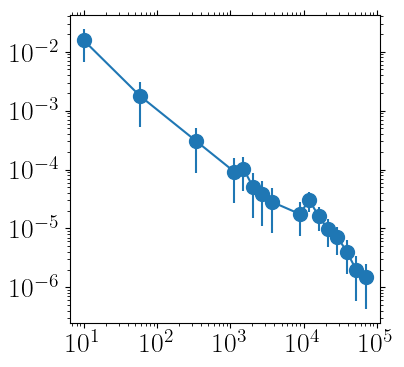

<AxesSubplot:>

In [172]:
test_data_grains, test_data_grains2nd = load_test_data(confParser['test data files']['test_data_file_path'], 
                                     confParser['test data files']['test_data_file_path2nd']
                                    )

hist, bins, err = utl.GetPDF(test_data_grains.grainSize, n_per_decade=8 )

utl.PltErr(bins,hist,yerr=err,
        yscale='log',
        xscale='log',
#           xlim=(1,1e6),
          )


open and load data from test_data.csv complete.


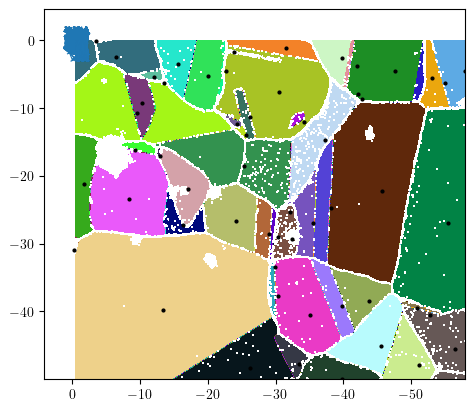

In [173]:
def main():
    if eval(confParser['flags']['remote_machine']):
        return
    
    test_data_grains, test_data_grains2nd = load_test_data(confParser['test data files']['test_data_file_path'], 
                                         confParser['test data files']['test_data_file_path2nd']
                                        )

    new_map = get_cmap(test_data_grains.shape[0])

    #--- plott grains
    id_matrix = np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path'],
              )
    n=id_matrix.T.shape[1]
    val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
    points=np.c_[test_data_grains[['x','y']]]
    [xlo,xhi]=[points[:,0].min(),points[:,0].max()]
    [ylo,yhi]=[points[:,1].min(),points[:,1].max()]
    plot_bitmap = True
    if not plot_bitmap:
        val[:,:]=0
    plt.imshow(val.T,
            #            id_matrix,
                        origin='lower',
                        extent = (yhi,ylo,xlo,xhi),
            #               extent = (0,-100,-100,0),
                        cmap=new_map
                      )

    #--- plot centers
    plot_centers=True
    pixel_cutoff=0
    filtr = test_data_grains['area']>pixel_cutoff
    points=np.c_[test_data_grains[filtr][['x','y']]]
    xt=points[:,0] 
    yt=points[:,1]

    #--- plot edges
    singlePixel = test_data_grains[test_data_grains['area']<=pixel_cutoff].index
    for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
        if i in singlePixel or j in singlePixel:
            continue
        x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
        y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
        if plot_centers:
            plt.plot(y,x,
                       '-',color='C0',
                     lw=.8,
                      )

    if plot_centers:
        plt.plot(yt,
                 xt,
                 '.',color='black',
                 markersize=4,
                )

    #--- range
#      xc=yc=-50
#     plt.xlim(xc+l/2,xc-l/2)
#     plt.ylim(yc-h/2,yc+h/2)
    plt.savefig('png/gnn.png',bbox_inches='tight',pad_inches=0.0,dpi=600)
    
main()

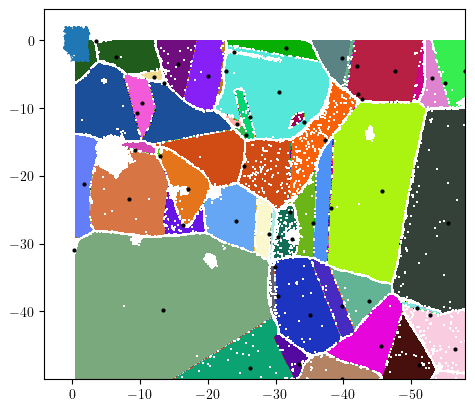

In [176]:
def main():
    if  eval(confParser['flags']['remote_machine']) or eval(confParser['flags']['without_edges']):
        return
    
    new_map = get_cmap(test_data_grains.shape[0])
    #--- plott grains
    id_matrix = np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path'],
              )
    n=id_matrix.T.shape[1]
    val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
    points=np.c_[test_data_grains[['x','y']]]
    [xlo,xhi]=[points[:,0].min(),points[:,0].max()]
    [ylo,yhi]=[points[:,1].min(),points[:,1].max()]
    plot_bitmap = True
    if not plot_bitmap:
        val[:,:]=0
    plt.imshow(val.T,
            #            id_matrix,
                        origin='lower',
                        extent = (yhi,ylo,xlo,xhi),
            #               extent = (0,-100,-100,0),
                        cmap=new_map
                      )

    #--- plot centers
    plot_centers=True
    pixel_cutoff=0
    filtr = test_data_grains['grainSize']>pixel_cutoff
    points=np.c_[test_data_grains[filtr][['x','y']]]
    xt=points[:,0] 
    yt=points[:,1]

    #--- plot edges
    singlePixel = test_data_grains[test_data_grains['grainSize']<=pixel_cutoff].index
    for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
        if i in singlePixel or j in singlePixel:
            continue
        x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
        y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
        if plot_centers:
            plt.plot(y,x,
                       '-',color='C0',
                     lw=.8,
                      )

    if plot_centers:
        plt.plot(yt,
                 xt,
                 '.',color='black',
                 markersize=4,
                )

    #--- range
#     l=h=30
#     xc=-40;yc=-60
#     plt.xlim(xc+l/2,xc-l/2)
#     plt.ylim(yc-h/2,yc+h/2)
    plt.savefig('png/gnnMagnified.png',bbox_inches='tight',pad_inches=0.0,dpi=600)
    
main()

In [203]:
class PlotGrains:
    def __init__(self,id_matrix):
    
        self.id_matrix = id_matrix #--- grain-id matrix 
        
    def reshape(self,grain_ids,val):
        self.val=np.zeros(self.id_matrix.shape[0]*self.id_matrix.shape[1]).\
        reshape((self.id_matrix.shape[0],self.id_matrix.shape[1]))
        for grainID in grain_ids:
            h=val[grain_ids==grainID][0]
            self.val[self.id_matrix==grainID]=h        

    def Bounds(self,points):
        [self.xlo,self.xhi]=[points[:,0].min(),points[:,0].max()]
        [self.ylo,self.yhi]=[points[:,1].min(),points[:,1].max()]

    def Mask(self,grainID_notindented):
        for grain_id in grainID_notindented.flatten(): #--- don't not show indented grains
                self.id_matrix[self.id_matrix == grain_id]=0
        
    def MaskField(self,grainID_notindented):
        for grain_id in grainID_notindented.flatten(): #--- not show indented grains
                self.val[self.id_matrix == grain_id] = np.nan

    def Transform(self):
        n=self.id_matrix.T.shape[1]
        self.id_matrix =np.array([self.id_matrix.T[:,(n-1)-j] for j in range(n)]) #--- transform
        
    def TransformField(self):
        n=self.val.T.shape[1]
        self.val = np.array([self.val.T[:,(n-1)-j] for j in range(n)]) #--- transform

        
    def PlotOrientation(self):
        new_map = get_cmap(len(set(self.id_matrix.flatten())))
        utl.PltBitmap(self.id_matrix.T,
                   xlim = (self.yhi,self.ylo),ylim = (self.xlo,self.xhi),
#                    xlabel='',ylabel='',
                      zscore=False,
                    cmap=new_map,
                    mask = self.id_matrix.T == 0,
                    title='png/indented2nd.png',
#                       Plot=True
                  )
    def PlotOrientationSingle(self,cords,**kwargs):
        new_map = get_cmap(len(set(self.id_matrix.flatten())))
#         print(self.__dict__)
        ax=utl.PltBitmap(self.id_matrix.T,
                   xlim = (self.yhi,self.ylo),ylim = (self.xlo,self.xhi),
                    xlabel='',ylabel='',
                      zscore=False,
                    cmap=new_map,
#                    mask = self.id_matrix.T == 0,
                    **kwargs
#                    title='png/indented2nd.png'
                  )
        ax.plot([cords[1]],[cords[0]],color='black',marker='.',markersize=20)

    def PlotField(self,**kwargs):
#        print('kwargs:',kwargs)
        utl.PltBitmap(self.val.T,
        #            id_matrix,
#                    origin='lower',
                      xlabel='',ylabel='',
                    xlim = (self.yhi,self.ylo),
                    ylim = (self.xlo,self.xhi),
                      zscore=False,
                      colorbar=True,
                    **kwargs
                  )
        
    def sub_matrix(self):
        (rows,cols)=self.id_matrix.nonzero() #--- associated with single grain
        filtr=~np.isnan(self.id_matrix[rows,cols]) #--- throw nans
        #--- bounds
        row_min = rows[filtr].min()
        row_max = rows[filtr].max()
        col_min = cols[filtr].min()
        col_max = cols[filtr].max()
        #--- xy bounds
        xmax = (1.0*col_max/self.id_matrix.shape[1])*(self.xhi-self.xlo)+self.xlo
        xmin = (1.0*col_min/self.id_matrix.shape[1])*(self.xhi-self.xlo)+self.xlo
        ymax = (1.0*row_max/self.id_matrix.shape[0])*(self.ylo-self.yhi)+self.yhi
        ymin = (1.0*row_min/self.id_matrix.shape[0])*(self.ylo-self.yhi)+self.yhi
        self.xhi=xmax
        self.xlo=xmin
        self.yhi=ymax
        self.ylo=ymin

        #--- sub matrix
        self.id_matrix = self.id_matrix[row_min:row_max,col_min:col_max]
    
    

        
# if not eval(confParser['flags']['remote_machine']):

#     plott = PlotGrains( np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) #--- bitmap of grain ids
#                       )
#     plott.Bounds(np.c_[test_data_grains[['x','y']]])
#     plott.Transform()
#     plott.Mask(grainID_notindented)
#     plott.PlotOrientation()



In [204]:
# filtr = test_data_grains.subBoundaryLength == 0
# grainID_notindented = np.c_[test_data_grains[filtr]['#grainID']].astype(int)
# test_data_grains[~filtr]

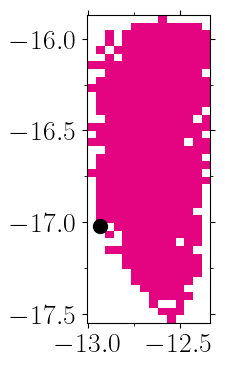

In [209]:
if not eval(confParser['flags']['remote_machine']):
    #--- mask every grain_indx != GrainIndex
    GrainIndex=5
    mask = np.zeros(test_data_grains.shape[0],dtype=bool)
    mask[GrainIndex]=True
    grainID_masked = np.c_[test_data_grains[~mask]['#grainID']].astype(int)

    #--- plot
    plott = PlotGrains( np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) #--- bitmap of grain ids
                      )
    plott.Bounds(np.c_[test_data_grains[['x','y']]])
    #
    plott.Transform()
    #
    plott.Mask(grainID_masked)
    #
    plott.sub_matrix()
    #
    plott.PlotOrientationSingle(list(test_data_grains.iloc[GrainIndex]['x y'.split()]), Plot=False)

x    -3.429627
y   -15.615640
Name: 10, dtype: float64

In [29]:

# h_mat=np.zeros(id_matrix.shape[0]*id_matrix.shape[1]).reshape((id_matrix.shape[0],id_matrix.shape[1]))
# h_mat.shape
# for grainID in test_data_grains['#grainID']:
#     h=test_data_grains[test_data_grains['#grainID']==grainID].iloc[0]['h(Gpa)']
#     h_mat[id_matrix==grainID]=h

    
# plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['ebsd_path']),
#                   )
# plott.reshape( np.c_[test_data_grains['#grainID']],np.c_[test_data_grains['h(Gpa)']])
# plott.Bounds(np.c_[test_data_grains[['x','y']]])
# plott.Transform()
# plott.TransformField()
# plott.MaskField(grainID_notindented)
# plott.Mask(grainID_notindented)
# plott.PlotField(cmap='bwr')


# Train

In [30]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class GnnRegressor(BaseEstimator):

    def __init__(self, **kwargs):
#        print('constructor call')
        for key, val in kwargs.items():
            setattr(self,key,val)
        #        self.param = kwargs
        # Create the model.
        self.model = EncodeProcessDecode(node_output_size=self.node_output_size)
        
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y,multi_output=True)
        # Store the classes seen during fit
    #         self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
    #         # Return the classifier
        return self

    def predict(self, X):
#         # Check if fit has been called
#        check_is_fitted(self)

        #         # Input validation
        X = check_array(X)

        #--- training base graph
        output_ops, latent_ops = self.model(self.input_graph, self.num_processing_steps_tr)

        # Training loss.
        loss_op_tr = []
        loss_op_va = []
        loss_op_ts = []
        corr_op_tr = []
        corr_op_va = []
        corr_op_ts = []

        for op in output_ops:
            loss_op_tr.append( create_loss_ops(self.target_nodes, op, self.train_mask,self.weight))
            loss_op_va.append( create_loss_ops(self.target_nodes, op, self.val_mask,self.weight))
            loss_op_ts.append( create_loss_ops(self.target_nodes, op, self.test_mask,self.weight))
            corr_op_tr.append( create_corr_ops(self.target_nodes, op, self.train_mask))
            corr_op_va.append( create_corr_ops(self.target_nodes, op, self.val_mask))
            corr_op_ts.append( create_corr_ops(self.target_nodes, op, self.test_mask))

        # Training loss across processing steps.
        loss_op_tr_sum = sum(loss_op_tr) / self.num_processing_steps_tr


        # Optimizer.
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        step_op = optimizer.minimize(loss_op_tr_sum)


        training_history = np.zeros((self.num_training_iterations, 3*self.num_processing_steps_tr)) 
        correlat_history = np.zeros((self.num_training_iterations, 3*self.num_processing_steps_tr)) 
        counter = 0


        # This cell resets the Tensorflow session, but keeps the same computational
        # graph.
        try:
          sess.close()
        except NameError:
          pass
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
#        pdb.set_trace()
        print(snt.format_variables(self.model.variables))

        best_corr = np.zeros((self.num_processing_steps_tr,3))
        best_val_loss = np.inf
        best_corr_loss = 0.0
        best_val_loss_all = np.inf*np.ones(self.num_processing_steps_tr)
        best_corr_loss_all = np.zeros(self.num_processing_steps_tr)
        last_improved = 0
        early_stopping_crit = self.num_training_iterations

        measure_val_by_loss= True
        print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

        # #--- training loop
        t0 = time.time()
        err_indx = 0 if self.stopping_criterion == 0 else 2
        for iteration in range(self.num_training_iterations):
            last_iteration = iteration
            train_values = sess.run({
                "step": step_op,
                "loss": loss_op_tr,
                "outputs": output_ops,
                "latents": latent_ops,
                "corr": corr_op_tr

            })


            test_values = sess.run({
                "loss_val":  loss_op_va,
                "loss_test": loss_op_ts,
                    "corr_val": corr_op_va,
                    "corr_test": corr_op_ts
            })
            
            #--- store losses at each iteration: training_history[counter]=[train_loss,val_loss,test_loss]
            training_history[counter, 0:self.num_processing_steps_tr] = train_values['loss']
            training_history[counter, self.num_processing_steps_tr:2*self.num_processing_steps_tr] = test_values['loss_val']
            training_history[counter, 2*self.num_processing_steps_tr:] = test_values['loss_test']

            correlat_history[counter, 0:self.num_processing_steps_tr] = np.median(train_values['corr'])
            correlat_history[counter, self.num_processing_steps_tr:2*self.num_processing_steps_tr] = np.median(test_values['corr_val'])
            correlat_history[counter, 2*self.num_processing_steps_tr:] = np.median(test_values['corr_test'])


            #--- print loss corresponding to the last block
            if(iteration+1) %100==0:
                print("%s, training %3.2e, validation %3.2e, test %3.2e, best loss %3.2e"
                      %(iteration+1,training_history[counter,self.num_processing_steps_tr-1], 
                        training_history[counter,2*self.num_processing_steps_tr-1],training_history[counter,-1], best_val_loss ))

                for i in range(self.num_processing_steps_tr):
                    if measure_val_by_loss:
                        cond =      (training_history[counter,err_indx*self.num_processing_steps_tr+i] < best_val_loss_all[i]) #--- training
                        cond_best = (training_history[counter,err_indx*self.num_processing_steps_tr+i] < best_val_loss)
        #             else:
        #                 cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
        #                 cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
                    if cond:
                        step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
        #                step_outputt[i] =  np.copy(sess.run(output_ops[i].nodes)) # sess.run(output_ops)	
        #                 pdb.set_trace()
                        best_corr[i,0] = stats.pearsonr( step_output[self.train_mask_np].flatten(),  np.array(self.target_nodes_np)[self.train_mask_np].flatten() )[0]
                        best_corr[i,1] = stats.pearsonr( step_output[self.val_mask_np].flatten(),   np.array(self.target_nodes_np)[self.val_mask_np].flatten() )[0]
                        best_corr[i,2] = stats.pearsonr( step_output[self.test_mask_np].flatten(),   np.array(self.target_nodes_np)[self.test_mask_np].flatten() )[0]
                        #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))

                        best_val_loss_all[i] = training_history[counter,err_indx*self.num_processing_steps_tr+i] #--- training
                        best_corr_loss_all[i] = correlat_history[counter,err_indx*self.num_processing_steps_tr+i]
                    if cond_best:
                        assert cond
                        best_output = np.copy(step_output)
                        best_latent = sess.run(latent_ops[i])
                        #print(best_latent.shape)
        #                    best_val_loss = training_history[counter,num_processing_steps_tr+i] #--- validation
        #                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
                        #
        #                 print('best condition met, loss_old=%3.2e'%best_val_loss)
                        best_val_loss = training_history[counter,err_indx*self.num_processing_steps_tr+i] #--- test
        #                 print('best condition met, loss_new=%3.2e'%best_val_loss)
                        best_corr_loss = correlat_history[counter,err_indx*self.num_processing_steps_tr+i]
                        last_improved = counter


            counter+=1 
            if counter > last_improved + early_stopping_crit:
                print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
                break


#        f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

        training_history = training_history[:counter]
        correlat_history = correlat_history[:counter]
        for i in range(self.num_processing_steps_tr):
            print("    %s steps:  best val res, r: training %6.5e, validation %6.5e, test %6.5e"%(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
            latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
        #     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



        # np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
        # np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
        # np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
        # np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)
        print('elapsed times:%ss'%(time.time()-t0))

        #         closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return best_output, training_history #self.y_[closest]
    
    def mse(self,y_act,y_pred):
        return mean_squared_error(y_act,y_pred)
    


## train-test

In [31]:
if eval(confParser['flags']['train_test']):
    if eval(confParser['Parameters']['split_type']) == 0: 
        tsp.train_test_split()
    elif eval(confParser['Parameters']['split_type']) == 1: 
        tsp.train_test_split_structured(np.c_[test_data_grains[['x','y']]])
    #
    gnnReg = GnnRegressor(
                            num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']),
                            num_training_iterations = eval(confParser['Parameters']['num_training_iterations']), 
                            learning_rate = eval(confParser['Parameters']['learning_rate']),
                            stopping_criterion = eval(confParser['Parameters']['stopping_criterion']),
                            input_graph=input_graph,
                            node_output_size = len(target_nodes_np[0]),
                            train_mask = tf.constant(tsp.train_mask, dtype=tf.bool),
                            test_mask  = tf.constant(tsp.test_mask , dtype=tf.bool),
                            val_mask   = tf.constant(tsp.test_mask  , dtype=tf.bool),
                            target_nodes = tf.constant(target_nodes_np),
                            train_mask_np = tsp.train_mask,
                            test_mask_np  = tsp.test_mask,
                            val_mask_np   = tsp.test_mask,
                            target_nodes_np = target_nodes_np,
                            weight = None )

    gnnReg.fit( np.array(static_graph_tr['nodes'])[tsp.train_mask],
                np.array(target_nodes_np)[tsp.train_mask] )

    best_output, training_history = gnnReg.predict(np.array(static_graph_tr['nodes']))

    mse_test = gnnReg.mse(np.array(target_nodes_np)[tsp.test_mask].flatten(),
                np.array(best_output[tsp.test_mask]).flatten())
    mse_train = gnnReg.mse(np.array(target_nodes_np)[tsp.train_mask].flatten(),
                np.array(best_output[tsp.train_mask]).flatten())
    !mkdir mse
    np.savetxt('mse/validation.txt',
               np.c_[mse_test,mse_train],
               header='test\ttrain')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode/graph_independent/node_model/node_output/b         100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode/graph_independent/node_model/node_output/w         8x100  float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent/graph_independent/edge_model/layer_norm/beta       8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent/graph_independent/edge_model/layer_norm/gamma      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/b        8      float32  glob

100, training 7.81e+04, validation 3.26e+04, test 3.26e+04, best loss inf
200, training 7.74e+04, validation 3.20e+04, test 3.20e+04, best loss 3.26e+04
300, training 7.63e+04, validation 3.11e+04, test 3.11e+04, best loss 3.20e+04
400, training 7.51e+04, validation 3.01e+04, test 3.01e+04, best loss 3.11e+04
500, training 7.36e+04, validation 2.89e+04, test 2.89e+04, best loss 3.01e+04
600, training 7.20e+04, validation 2.75e+04, test 2.75e+04, best loss 2.89e+04
700, training 7.01e+04, validation 2.61e+04, test 2.61e+04, best loss 2.75e+04
800, training 6.82e+04, validation 2.45e+04, test 2.45e+04, best loss 2.61e+04
900, training 6.62e+04, validation 2.29e+04, test 2.29e+04, best loss 2.45e+04
1000, training 6.41e+04, validation 2.12e+04, test 2.12e+04, best loss 2.29e+04
1100, training 6.19e+04, validation 1.96e+04, test 1.96e+04, best loss 2.12e+04
1200, training 5.98e+04, validation 1.80e+04, test 1.80e+04, best loss 1.96e+04
1300, training 5.77e+04, validation 1.64e+04, test 1.6

10400, training 1.59e+03, validation 7.15e+02, test 7.15e+02, best loss 4.29e+02
10500, training 1.44e+03, validation 7.20e+02, test 7.20e+02, best loss 4.29e+02
10600, training 1.30e+03, validation 7.48e+02, test 7.48e+02, best loss 4.29e+02
10700, training 1.17e+03, validation 7.31e+02, test 7.31e+02, best loss 4.29e+02
10800, training 1.05e+03, validation 7.17e+02, test 7.17e+02, best loss 4.29e+02
10900, training 9.39e+02, validation 7.41e+02, test 7.41e+02, best loss 4.29e+02
11000, training 8.41e+02, validation 7.36e+02, test 7.36e+02, best loss 4.29e+02
11100, training 7.49e+02, validation 7.21e+02, test 7.21e+02, best loss 4.29e+02
11200, training 6.61e+02, validation 6.79e+02, test 6.79e+02, best loss 4.29e+02
11300, training 6.00e+02, validation 7.05e+02, test 7.05e+02, best loss 4.29e+02
11400, training 5.14e+02, validation 7.06e+02, test 7.06e+02, best loss 4.29e+02
11500, training 4.52e+02, validation 6.79e+02, test 6.79e+02, best loss 4.29e+02
11600, training 3.97e+02, va

20600, training 1.08e+01, validation 2.44e+02, test 2.44e+02, best loss 2.40e+02
20700, training 1.07e+01, validation 2.24e+02, test 2.24e+02, best loss 2.40e+02
20800, training 1.08e+01, validation 2.31e+02, test 2.31e+02, best loss 2.21e+02
20900, training 1.03e+01, validation 2.09e+02, test 2.09e+02, best loss 2.21e+02
21000, training 1.03e+01, validation 2.07e+02, test 2.07e+02, best loss 2.04e+02
21100, training 1.03e+01, validation 2.02e+02, test 2.02e+02, best loss 2.01e+02
21200, training 1.01e+01, validation 1.98e+02, test 1.98e+02, best loss 1.95e+02
21300, training 9.98e+00, validation 1.78e+02, test 1.78e+02, best loss 1.92e+02
21400, training 1.01e+01, validation 1.74e+02, test 1.74e+02, best loss 1.72e+02
21500, training 1.16e+01, validation 1.99e+02, test 1.99e+02, best loss 1.70e+02
21600, training 1.23e+01, validation 1.86e+02, test 1.86e+02, best loss 1.70e+02
21700, training 9.92e+00, validation 1.80e+02, test 1.80e+02, best loss 1.70e+02
21800, training 9.81e+00, va

30800, training 5.47e+00, validation 2.45e+02, test 2.45e+02, best loss 1.46e+02
30900, training 4.87e+00, validation 2.43e+02, test 2.43e+02, best loss 1.46e+02
31000, training 5.27e+00, validation 2.44e+02, test 2.44e+02, best loss 1.46e+02
31100, training 9.07e+00, validation 2.61e+02, test 2.61e+02, best loss 1.46e+02
31200, training 4.68e+00, validation 2.37e+02, test 2.37e+02, best loss 1.46e+02
31300, training 4.90e+00, validation 2.35e+02, test 2.35e+02, best loss 1.46e+02
31400, training 5.03e+00, validation 2.39e+02, test 2.39e+02, best loss 1.46e+02
31500, training 5.10e+00, validation 2.53e+02, test 2.53e+02, best loss 1.46e+02
31600, training 6.31e+00, validation 2.55e+02, test 2.55e+02, best loss 1.46e+02
31700, training 4.60e+00, validation 2.48e+02, test 2.48e+02, best loss 1.46e+02
31800, training 4.91e+00, validation 2.56e+02, test 2.56e+02, best loss 1.46e+02
31900, training 4.78e+00, validation 2.43e+02, test 2.43e+02, best loss 1.46e+02
32000, training 7.54e+00, va

41000, training 5.31e+00, validation 3.96e+02, test 3.96e+02, best loss 1.46e+02
41100, training 3.70e+00, validation 3.82e+02, test 3.82e+02, best loss 1.46e+02
41200, training 3.76e+00, validation 3.84e+02, test 3.84e+02, best loss 1.46e+02
41300, training 4.13e+00, validation 3.77e+02, test 3.77e+02, best loss 1.46e+02
41400, training 3.71e+00, validation 3.86e+02, test 3.86e+02, best loss 1.46e+02
41500, training 3.87e+00, validation 3.97e+02, test 3.97e+02, best loss 1.46e+02
41600, training 4.39e+00, validation 3.86e+02, test 3.86e+02, best loss 1.46e+02
41700, training 3.75e+00, validation 3.86e+02, test 3.86e+02, best loss 1.46e+02
41800, training 3.81e+00, validation 3.97e+02, test 3.97e+02, best loss 1.46e+02
41900, training 3.89e+00, validation 3.86e+02, test 3.86e+02, best loss 1.46e+02
42000, training 3.67e+00, validation 3.95e+02, test 3.95e+02, best loss 1.46e+02
42100, training 3.73e+00, validation 3.85e+02, test 3.85e+02, best loss 1.46e+02
42200, training 3.72e+00, va

51200, training 3.46e+00, validation 4.64e+02, test 4.64e+02, best loss 1.46e+02
51300, training 3.45e+00, validation 4.56e+02, test 4.56e+02, best loss 1.46e+02
51400, training 3.70e+00, validation 4.47e+02, test 4.47e+02, best loss 1.46e+02
51500, training 3.36e+00, validation 4.64e+02, test 4.64e+02, best loss 1.46e+02
51600, training 3.51e+00, validation 4.51e+02, test 4.51e+02, best loss 1.46e+02
51700, training 3.47e+00, validation 4.64e+02, test 4.64e+02, best loss 1.46e+02
51800, training 4.39e+00, validation 4.86e+02, test 4.86e+02, best loss 1.46e+02
51900, training 3.59e+00, validation 4.75e+02, test 4.75e+02, best loss 1.46e+02
52000, training 3.75e+00, validation 4.75e+02, test 4.75e+02, best loss 1.46e+02
52100, training 3.49e+00, validation 4.56e+02, test 4.56e+02, best loss 1.46e+02
52200, training 3.36e+00, validation 4.68e+02, test 4.68e+02, best loss 1.46e+02
52300, training 3.39e+00, validation 4.68e+02, test 4.68e+02, best loss 1.46e+02
52400, training 4.09e+00, va

61400, training 3.63e+01, validation 4.50e+02, test 4.50e+02, best loss 1.46e+02
61500, training 3.47e+01, validation 4.54e+02, test 4.54e+02, best loss 1.46e+02
61600, training 5.03e+01, validation 4.66e+02, test 4.66e+02, best loss 1.46e+02
61700, training 3.18e+01, validation 4.66e+02, test 4.66e+02, best loss 1.46e+02
61800, training 3.38e+01, validation 4.67e+02, test 4.67e+02, best loss 1.46e+02
61900, training 2.96e+01, validation 4.82e+02, test 4.82e+02, best loss 1.46e+02
62000, training 2.87e+01, validation 4.85e+02, test 4.85e+02, best loss 1.46e+02
62100, training 3.13e+01, validation 5.01e+02, test 5.01e+02, best loss 1.46e+02
62200, training 2.51e+01, validation 4.99e+02, test 4.99e+02, best loss 1.46e+02
62300, training 2.64e+01, validation 5.03e+02, test 5.03e+02, best loss 1.46e+02
62400, training 2.58e+01, validation 5.12e+02, test 5.12e+02, best loss 1.46e+02
62500, training 2.49e+01, validation 5.14e+02, test 5.14e+02, best loss 1.46e+02
62600, training 2.51e+01, va

71600, training 6.47e+00, validation 3.56e+02, test 3.56e+02, best loss 1.46e+02
71700, training 8.44e+00, validation 3.80e+02, test 3.80e+02, best loss 1.46e+02
71800, training 6.54e+00, validation 3.54e+02, test 3.54e+02, best loss 1.46e+02
71900, training 8.59e+00, validation 3.52e+02, test 3.52e+02, best loss 1.46e+02
72000, training 6.90e+00, validation 3.58e+02, test 3.58e+02, best loss 1.46e+02
72100, training 8.63e+00, validation 3.69e+02, test 3.69e+02, best loss 1.46e+02
72200, training 1.27e+01, validation 4.00e+02, test 4.00e+02, best loss 1.46e+02
72300, training 7.81e+00, validation 4.36e+02, test 4.36e+02, best loss 1.46e+02
72400, training 7.68e+00, validation 4.58e+02, test 4.58e+02, best loss 1.46e+02
72500, training 6.91e+00, validation 4.29e+02, test 4.29e+02, best loss 1.46e+02
72600, training 6.72e+00, validation 4.00e+02, test 4.00e+02, best loss 1.46e+02
72700, training 6.90e+00, validation 3.70e+02, test 3.70e+02, best loss 1.46e+02
72800, training 6.86e+00, va

81800, training 4.19e+00, validation 3.85e+02, test 3.85e+02, best loss 1.46e+02
81900, training 4.25e+00, validation 3.79e+02, test 3.79e+02, best loss 1.46e+02
82000, training 4.20e+00, validation 3.78e+02, test 3.78e+02, best loss 1.46e+02
82100, training 4.15e+00, validation 3.83e+02, test 3.83e+02, best loss 1.46e+02
82200, training 4.30e+00, validation 3.79e+02, test 3.79e+02, best loss 1.46e+02
82300, training 4.80e+00, validation 4.02e+02, test 4.02e+02, best loss 1.46e+02
82400, training 4.60e+00, validation 3.80e+02, test 3.80e+02, best loss 1.46e+02
82500, training 5.99e+00, validation 3.62e+02, test 3.62e+02, best loss 1.46e+02
82600, training 4.23e+00, validation 3.84e+02, test 3.84e+02, best loss 1.46e+02
82700, training 3.87e+00, validation 3.76e+02, test 3.76e+02, best loss 1.46e+02
82800, training 4.30e+00, validation 3.83e+02, test 3.83e+02, best loss 1.46e+02
82900, training 4.35e+00, validation 3.67e+02, test 3.67e+02, best loss 1.46e+02
83000, training 3.91e+00, va

92000, training 3.22e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
92100, training 3.25e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
92200, training 3.22e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
92300, training 3.53e+00, validation 1.08e+03, test 1.08e+03, best loss 1.46e+02
92400, training 4.45e+00, validation 1.11e+03, test 1.11e+03, best loss 1.46e+02
92500, training 3.23e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
92600, training 3.21e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
92700, training 3.23e+00, validation 1.08e+03, test 1.08e+03, best loss 1.46e+02
92800, training 3.39e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
92900, training 3.25e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
93000, training 3.27e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
93100, training 3.35e+00, validation 1.09e+03, test 1.09e+03, best loss 1.46e+02
93200, training 3.19e+00, va

## Learning curve

In [32]:
def learning_curve(train_sizes,cv):
    mse={}
    mse_training={}
    for keys in cv:
        full_train_set = cv[keys]['train']
        test_set = cv[keys]['test']
        mse[keys]=[]
        mse_training[keys]=[]
        for fraction in train_sizes:
            partial_set = GetSubset(full_train_set,fraction)
            print('training size=',np.sum(partial_set))
            
            #--- train
            gnnReg = GnnRegressor(
                        num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']),
                        num_training_iterations = eval(confParser['Parameters']['num_training_iterations']), 
                        learning_rate = eval(confParser['Parameters']['learning_rate']),
                        stopping_criterion = eval(confParser['Parameters']['stopping_criterion']),
                        input_graph=input_graph,
                        node_output_size = len(target_nodes_np[0]),
                        train_mask = tf.constant(partial_set, dtype=tf.bool),
                        test_mask  = tf.constant(test_set , dtype=tf.bool),
                        val_mask   = tf.constant(test_set  , dtype=tf.bool),
                        target_nodes = tf.constant(target_nodes_np),
                        train_mask_np = tsp.train_mask,
                        test_mask_np  = tsp.test_mask,
                        val_mask_np   = tsp.test_mask,
                        target_nodes_np = target_nodes_np,
                        weight = None )

            gnnReg.fit( np.array(static_graph_tr['nodes'])[partial_set],
                        np.array(target_nodes_np)[partial_set] )

            prediction, _ = gnnReg.predict(np.array(static_graph_tr['nodes']))

            mse[keys].append(mean_squared_error(np.array(target_nodes_np)[test_set].flatten(),
                   np.array(prediction[test_set]).flatten()))
            mse_training[keys].append(mean_squared_error(np.array(target_nodes_np)[partial_set].flatten(),
                   np.array(prediction[partial_set]).flatten()))
    return mse, mse_training



In [33]:
if eval(confParser['flags']['learning_curve']):
    t0=time.time()
    #--- learning curve
    train_sizes= [eval(confParser['Parameters']['train_size_learning'])]
    n_cv = int(eval(confParser['Parameters']['n_cross_val']))
    seed = eval(confParser['Parameters']['seed'])
    #
    if eval(confParser['Parameters']['split_type']) == 0: 
        tsp.train_test_split_cv(n_cv) #--- random split
    elif eval(confParser['Parameters']['split_type']) == 1: 
    #--- structured split
        tsp.train_test_split_cv_structured(np.c_[test_data_grains[['x','y']]],
                                                         (int(n_cv**.5),int(n_cv**.5))
                                                         )

    #np.array([0.1  , 0.325, 0.55 , 0.775, 1.   ]) # np.arange(0.1,1.1,0.1) #
    mse_test, mse_training=learning_curve(train_sizes=train_sizes, 
                               cv=tsp.mask_dic,
                               )
    print('elapsed times:%ss'%(time.time()-t0))

    #--- plot
    #--- test
#     yerr = np.std(np.c_[list(map(lambda x:x,mse_test.values()))],axis=0)/np.sqrt(len(mse_test))
#     ydata = np.mean(np.c_[list(map(lambda x:x,mse_test.values()))],axis=0)
#     #--- training 
#     yerr_tr = np.std(np.c_[list(map(lambda x:x,mse_training.values()))],axis=0)/np.sqrt(len(mse_training))
#     ydata_tr = np.mean(np.c_[list(map(lambda x:x,mse_training.values()))],axis=0)
    utl.PltErr(np.ones(n_cv)*train_sizes,
               np.array(list(mse_test.values())).flatten(),
               yscale='log',
              xstr='size',
               ystr='mse',
              )
    #--- write on disc
    !mkdir mse
    output_mat = np.c_[np.ones(n_cv)*train_sizes,
                       np.array(list(mse_test.values())).flatten(),
                       np.array(list(mse_training.values())).flatten(),
     ]
    np.savetxt('mse/learning_curve.txt',
                output_mat,
#               np.c_[train_sizes,ydata,yerr,ydata_tr,yerr_tr],
#               header='train_sizes\tmse_test\terr_test\tmse_training\terr_training'
                header='train_sizes mse_test mse_training'
    )               


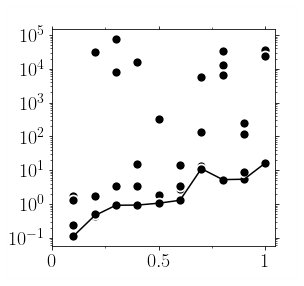

In [34]:
if not eval(confParser['flags']['remote_machine']):
    ncv=4
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))
    #
    ax = utl.PltErr(None,None,Plot=False)
    #--- number of train. sizes
    nmodel=10
    for imodel in range(nmodel):
        #--- parse
        data = np.loadtxt('learning_curve_structured%s/Run0/mse/learning_curve.txt'%imodel)
        sdata = data.copy() 
        #--- min
        ydata = np.min(sdata,axis=0) if imodel == 0 else np.c_[ydata,np.min(sdata,axis=0)]
#        np.std(sdata,axis=0)/np.sqrt(ncv)
        sizee = sdata[:,0]
        mse_test = sdata[:,1]
        mse_train = sdata[:,2]
        #--- plot scattered points
        utl.PltErr(sizee,mse_train,
                    attrs=symbols.GetAttrs(count=0,fmt='.',label=r'$\mathrm{Test}$' if imodel == 0 else ''),
                   ax=ax,Plot=False)
    #--- plot minimum
    sizes=ydata[0,:]
    mse_test_min = ydata[1,:]
    mse_train_min = ydata[2,:]
    utl.PltErr(sizes, mse_train_min,
               attrs={'fmt':'-','color':'black'},
               yscale='log',
#               legend=legend.Get(),
               title = 'mse/learning_curve_train.png',
#               ylim=(1e3,1e5),
#               ylim=(1e2,2e5),
               xticks=(['$0$','$0.5$','$1$'],[0,0.5,1]),
#               yticks=(['$2$','$6$','$10$'],[2000,6000,10000]),
               DrawFrame=(0.2,0.1,0.15,0.1,0.01),
               ax=ax)

## learning rate

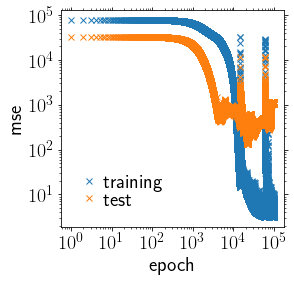

mkdir: mse: File exists


In [35]:
if eval(confParser['flags']['train_test']):
    iproc=2
    legend=utl.Legends()
    legend.Set()
    num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr'])
    ax=utl.PltErr(range(training_history.shape[0]),
               training_history[:,0*num_processing_steps_tr+iproc],
               attrs={'fmt':'x','label':'training'},
               xscale='log',
               yscale='log',
                  Plot=False,
              )

    utl.PltErr(range(training_history.shape[0]),
               training_history[:,1*num_processing_steps_tr+iproc],
               attrs={'fmt':'x','label':'test'},
               xscale='log',
               yscale='log',
               ax=ax,
               legend=legend.Get(),
               xstr='epoch',
               ystr='mse',
              )

    !mkdir mse
    np.savetxt('mse/learning_rate.txt',
               np.c_[np.arange(training_history.shape[0])+1,training_history[:,0*num_processing_steps_tr+iproc],training_history[:,1*num_processing_steps_tr+iproc]],
                           header='epoch,training\ttest')

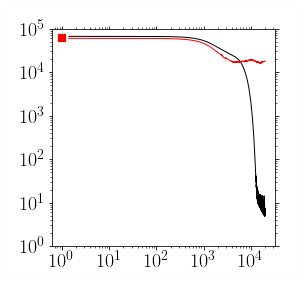

In [36]:
if not eval(confParser['flags']['remote_machine']):
    sdata = np.loadtxt('hardness_best_train/Run2/mse/learning_rate.txt')

    symbols = utl.Symbols()
    legend=utl.Legends()
    legend.Set()
    ax=utl.PltErr(sdata[:,0],
                  sdata[:,1],
    #              attrs={'fmt':'-','label':'training'},
                  attrs=symbols.GetAttrs(count=0,fmt='-',label=r'$\mathrm{train}$',nevery=200000),
                  Plot=False,
              )

    utl.PltErr(sdata[:,0],
               sdata[:,2],
                  attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{test}$',nevery=200000),
               xscale='log',
               yscale='log',
               ax=ax,
#               xlim=(1,1e7),
               ylim=(1e0,1e5),
#               legend=legend.Get(),
               title='png/learning_rate_train.png',
               DrawFrame=(0.2,0.1,0.15,0.1,0.01)
              )

## validation curve

In [37]:
def GetStat(mse_test):
    mse=np.array(list(mse_test.values())).flatten()
    return mse.mean(), mse.std()

if eval(confParser['flags']['validation_curve']):
    n_cv = int(eval(confParser['Parameters']['n_cross_val']))
    seed = eval(confParser['Parameters']['seed'])
    #
    if eval(confParser['Parameters']['split_type']) == 0: 
        tsp.train_test_split_cv(n_cv) #--- random split
    elif eval(confParser['Parameters']['split_type']) == 1: 
    #--- structured split
        tsp.train_test_split_cv_structured(np.c_[test_data_grains[['x','y']]],
                                                         (int(n_cv**.5),int(n_cv**.5))
                                                         )
    mse_test, mse_training=learning_curve(train_sizes=[1.0], 
                               cv=tsp.mask_dic)
    #
    !mkdir mse
    np.savetxt('mse/validation_curve.txt',
               np.c_[np.c_[GetStat(mse_test),GetStat(mse_training)].flatten()].T,
               header='mse_test\tmse_train\tmse_test_err\tmse_train_err')

In [38]:
# if not eval(confParser['flags']['remote_machine']):
#     symbols=utl.Symbols()
#     #
#     legend=utl.Legends()
#     legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

#     ax = utl.PltErr(None,None,Plot=False)

#     nmodel=6
#     for imodel in range(nmodel):
#         mse_train_test = np.loadtxt('validation%s/Run0/mse/validation_curve.txt'%imodel)

#         utl.PltErr([imodel],[mse_train_test[1]],
#                    yerr=[mse_train_test[3]],
#                    ax=ax,
#                    attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$' if imodel == 0 else ''),
#                    Plot=False)
#         utl.PltErr([imodel],[mse_train_test[0]],
#                    yerr=[mse_train_test[2]],
#                     attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$' if imodel == 0 else ''),
#                    ax=ax,Plot=False)

#     utl.PltErr(None,None,
#                yscale='log',
# #               legend=legend.Get(),
#                title = 'mse/validation_curve.png',
#                ylim=(1,1e5),
#                xticks=(['$\mathrm{Set}1$','$\mathrm{Set}2$','$\mathrm{Set}3$','$\mathrm{Set}4$','$\mathrm{Set}5$','$\mathrm{Set}6$'],
#                        [0,1,2,3,4,5]),
#                ax=ax)

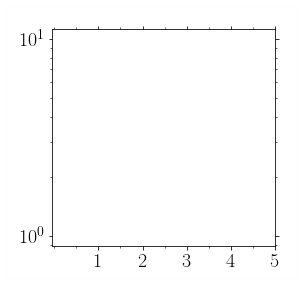

In [39]:
if not eval(confParser['flags']['remote_machine']):
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

    ax = utl.PltErr(None,None,Plot=False)

    mse_test = {}
    mse_train = {}
    nmodel=63
    tmp={}
    for imodel in range(nmodel):
#        if imodel == 58: continue 
#         print(imodel)
        try:
            mse_train_test = np.loadtxt('model_validation%s/Run0/mse/validation.txt'%imodel)
            #--- subset size
            confParser0 = configparser.ConfigParser()
            confParser0.read('model_validation%s/Run0/config.ini'%imodel)
            p=len(confParser0['Parameters']['attributes'].split())
            if p > 7: continue
            #
            mse_test.setdefault(p,[]).append(mse_train_test[0])
            mse_train.setdefault(p,[]).append(mse_train_test[1])
            tmp.setdefault(p,[]).append([mse_train_test[0],imodel])
            
            
        except:
#            print('imodel=',imodel)
#            traceback.print_exc()
            continue
#         if p==2: # and confParser0['Parameters']['attributes']=='x y':
#             print(confParser0['Parameters']['attributes'])
#         else:
#             continue
                
        #
        utl.PltErr([p-2],[mse_train_test[1]],
#                   yerr=[mse_train_test[3]],
                   ax=ax,
                   attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$' if imodel == 0 else ''),
                   Plot=False)
#         utl.PltErr([p-2],[mse_train_test[0]],
# #                   yerr=[mse_train_test[2]],
#                     attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$' if imodel == 0 else ''),
#                    ax=ax,Plot=False)

    xdata = list(map(lambda x:x,mse_test.keys()))
    ydata_train = list(map(lambda x:np.min(mse_train[x]),mse_test.keys()))
    ydata_test = list(map(lambda x:np.min(mse_test[x]),mse_test.keys()))
    utl.PltErr(np.array(xdata)-2,ydata_train,
               yscale='log',
               attrs={'fmt':'-','color':'black'},
#               legend=legend.Get(),
               title = 'mse/validation_curve_train.png',
#               ylim=(1e3,1e5),
#               ylim=(1e1,1e3),
               xticks=(['$1$','$2$','$3$','$4$','$5$'],[1,2,3,4,5]),
#               yticks=(['$2$','$6$','$10$'],[2000,6000,10000]),
               DrawFrame=(0.2,0.1,0.15,0.1,0.01),
               ax=ax)

In [40]:
# ss=[]
# for x in tmp.keys():
#     s=tmp[x]
#     s.sort()
#     print('# of features:',x)
#     irun=s[0][1]
#     confParser0.read('model_validation%s/Run0/config.ini'%irun)
#     print(confParser0['Parameters']['attributes'].split())
#     ss+=confParser0['Parameters']['attributes'].split()


In [41]:
# ss.sort()
# ss

In [42]:
# #--- set parameters
# #SEED =1 #44416664
# num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']) #3
# #--- Data / training parameters.
# num_training_iterations = eval(confParser['Parameters']['num_training_iterations']) #20000 #8000 #000#0 #20000
# learning_rate = eval(confParser['Parameters']['learning_rate']) #1e-2/4 #7.5e-6

# #np.random.seed(SEED)
# #tf.set_random_seed(SEED)
# #tf.random.set_seed(SEED)

# train_mask = tf.constant(train_mask_np, dtype=tf.bool)
# test_mask  = tf.constant(test_mask_np , dtype=tf.bool)
# val_mask   = tf.constant(val_mask_np  , dtype=tf.bool)

# target_nodes = tf.constant(target_nodes_np)
# weight = tf.constant(weight_np)
# weight = None ##NOTE comment out if weights wanted 


# # Create the model.
# node_output_size = len(target_nodes_np[0])
# model = EncodeProcessDecode(node_output_size=node_output_size)
# #print(model.summary())

# #--- training base graph
# output_ops, latent_ops = model(input_graph, num_processing_steps_tr) #[-1]
# # Training loss.
# loss_op_tr = []
# loss_op_va = []
# loss_op_ts = []
# corr_op_tr = []
# corr_op_va = []
# corr_op_ts = []

# for op in output_ops:
#     loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
#     loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
#     loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
#     corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
#     corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
#     corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

# # Training loss across processing steps.
# loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


# # Optimizer.
# optimizer = tf.train.AdamOptimizer(learning_rate)
# step_op = optimizer.minimize(loss_op_tr_sum)


# training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
# correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
# counter = 0


# # This cell resets the Tensorflow session, but keeps the same computational
# # graph.
# try:
#   sess.close()
# except NameError:
#   pass
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# print(snt.format_variables(model.variables))

# best_corr = np.zeros((num_processing_steps_tr,3))
# best_val_loss = np.inf
# best_corr_loss = 0.0
# best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
# best_corr_loss_all = np.zeros(num_processing_steps_tr)
# last_improved = 0
# early_stopping_crit = num_training_iterations #1000
# step_outputt = [[],[],[]]

# measure_val_by_loss= True
# print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# # #--- training loop
# t0 = time.time()
# for iteration in range(num_training_iterations):
#     last_iteration = iteration
#     train_values = sess.run({
#         "step": step_op,
#         "loss": loss_op_tr,
#         "outputs": output_ops,
#         "latents": latent_ops,
#         "corr": corr_op_tr

#     })
    

#     test_values = sess.run({
#         "loss_val":  loss_op_va,
#         "loss_test": loss_op_ts,
#             "corr_val": corr_op_va,
#             "corr_test": corr_op_ts
#     })
#     training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
#     training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
#     training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

#     correlat_history[counter, 0:num_processing_steps_tr] = np.median(train_values['corr'])
#     correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = np.median(test_values['corr_val'])
#     correlat_history[counter, 2*num_processing_steps_tr:] = np.median(test_values['corr_test'])



#     if(iteration+1) %100==0:
#         print("%s, training %3.2e, validation %3.2e, test %3.2e, best loss %3.2e"
#               %(iteration+1,training_history[counter,num_processing_steps_tr-1], 
#                 training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1], best_val_loss ))

#         for i in range(num_processing_steps_tr):
#             if measure_val_by_loss:
# #                cond =      (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i]) #--- validation
# #                cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
#                 cond =      (training_history[counter,0+i] < best_val_loss_all[i]) #--- training
#                 cond_best = (training_history[counter,0+i] < best_val_loss)
# #             else:
# #                 cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
# #                 cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
#             if cond:
#                 step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
# #                step_outputt[i] =  np.copy(sess.run(output_ops[i].nodes)) # sess.run(output_ops)	
# #                 pdb.set_trace()
#                 best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
#                 best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
#                 best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
#                 #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))

# #                best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i] #--- validation
# #                best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]

#                 best_val_loss_all[i] = training_history[counter,0+i] #--- training
#                 best_corr_loss_all[i] = correlat_history[counter,0+i]
#             if cond_best:
#                 assert cond
#                 best_output = np.copy(step_output)
#                 best_latent = sess.run(latent_ops[i])
#                 #print(best_latent.shape)
# #                    best_val_loss = training_history[counter,num_processing_steps_tr+i] #--- validation
# #                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
#                 #
# #                 print('best condition met, loss_old=%3.2e'%best_val_loss)
#                 best_val_loss = training_history[counter,0+i] #--- training
# #                 print('best condition met, loss_new=%3.2e'%best_val_loss)
#                 best_corr_loss = correlat_history[counter,0+i]
#                 last_improved = counter
                    

#     counter+=1 
#     if counter > last_improved + early_stopping_crit:
#         print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
#         break


# f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

# training_history = training_history[:counter]
# correlat_history = correlat_history[:counter]
# for i in range(num_processing_steps_tr):
#     print("    %s steps:  best val res, r: training %6.5e, validation %6.5e, test %6.5e"%(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
#     latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
# #     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



# # np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
# # np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
# # np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
# # np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)
# print('elapsed times:%ss'%(time.time()-t0))

In [43]:
# i=1
# step_output =  sess.run(output_ops[i].nodes)
# best_output = np.copy(step_output)

In [44]:
# with sess.as_default():
#     print(output_ops[0].receivers.eval().shape)

## predictions
### training set

[941, 522, 861, 728, 1023, 646, 359, 595, 325]
grain_indx= 941 mse= 1.1815911154475875 area= 678.953


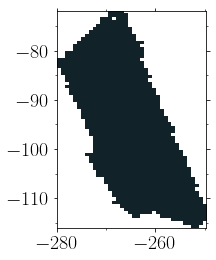

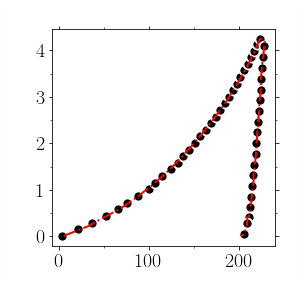

grain_indx= 522 mse= 1.1840774140501293 area= 699.4602


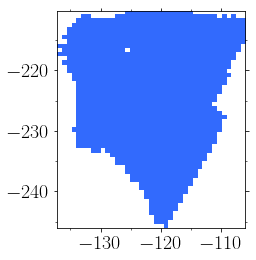

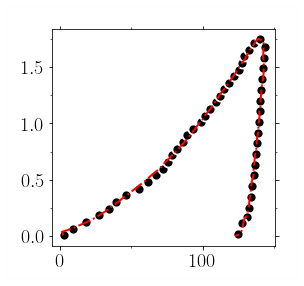

grain_indx= 861 mse= 1.2176596482966546 area= 263.8218


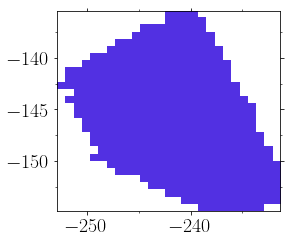

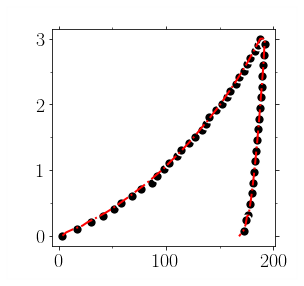

grain_indx= 728 mse= 1.3559755946955976 area= 839.6848


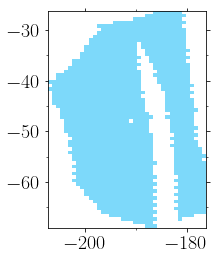

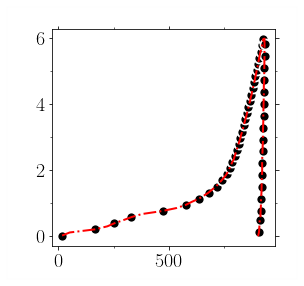

grain_indx= 1023 mse= 1.4848850567718344 area= 78.14888


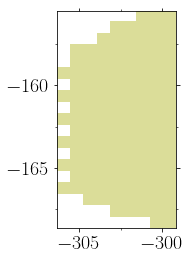

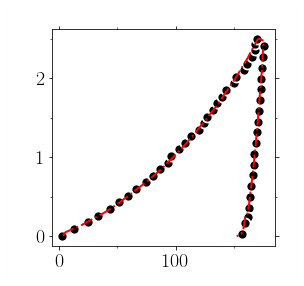

grain_indx= 646 mse= 1.4891957480946245 area= 156.2978


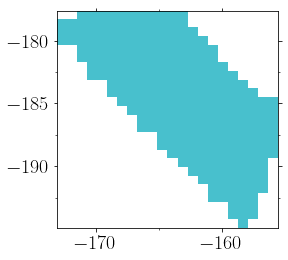

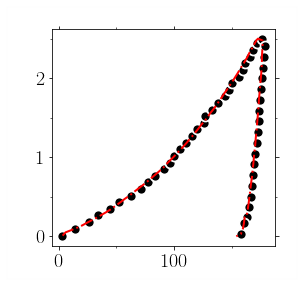

grain_indx= 359 mse= 1.5848245885907033 area= 172.9252


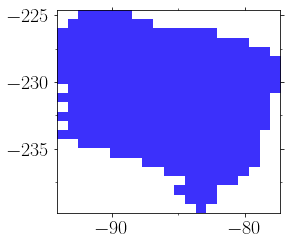

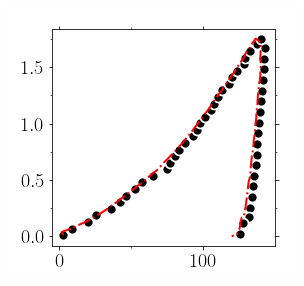

grain_indx= 595 mse= 1.6724072746767673 area= 370.2373


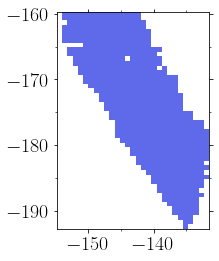

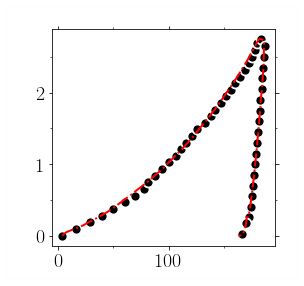

grain_indx= 325 mse= 1.6806496489611626 area= 1647.223


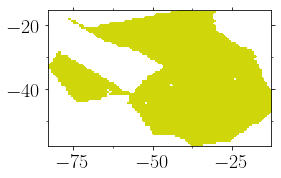

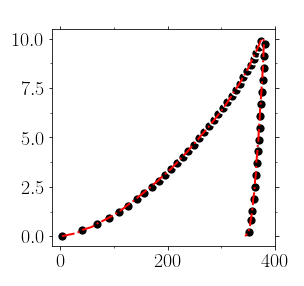

In [45]:
def Plott(indices,test_mask_np,best_output,title):
    #--- plot
    count = 0
    !mkdir -p png/test_set
    for grain_indx in indices:#range(len(target_nodes_np)):
        assert test_mask_np[grain_indx]
    #     if not test_mask_np[grain_indx]:
    #         continue
    #    print('grain_indx=',grain_indx,'area=',test_data_grains['grainSize'].iloc[grain_indx])
    #     if grain_indx != indxx:
    #         continue
        print('grain_indx=',grain_indx,'mse=',msee[grain_indx],'area=',test_data_grains['area'].iloc[grain_indx])
        #--- plot grains
        #--- mask every grain_indx != GrainIndex
        GrainIndex=grain_indx
        mask = np.zeros(test_data_grains.shape[0],dtype=bool)
        mask[GrainIndex]=True
        grainID_masked = np.c_[test_data_grains[~mask]['#grainID']].astype(int)

        #--- plot
        plott = PlotGrains( np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) #--- bitmap of grain ids
                          )
        plott.Bounds(np.c_[test_data_grains[['x','y']]])
        #
        plott.Transform()
        #
        plott.Mask(grainID_masked)
        #
        plott.sub_matrix()
        #
        plott.PlotOrientationSingle(title='png/grain_indx%s_%s.png'%(count,title))

        ax=utl.PltErr(None,None,Plot=False)
        utl.PltErr(
    #                range(len(target_nodes_np[grain_indx])),
                   target_nodes_np[grain_indx], 
                   forces[grain_indx],
                   attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
                    Plot=False,
                   ax=ax
                     )

        ax=utl.PltErr(
                   best_output[grain_indx], #step_output[grain_indx],#best_output[grain_indx],
                           forces[grain_indx],

                   attrs={'fmt':'-.','lw':2,'color':'red'},
                   ax=ax,
                   Plot=False,
                  )

        utl.PltErr(None,None,
                   ax=ax,
                   title='png/prediction%s_%s.png'%(count,title),
                  dpi=150,
    #                xstr='depth',
    #                ystr='load',
                   DrawFrame=(0.2,0.1,0.15,0.1,0.01),
                  )
        count += 1

if not eval(confParser['flags']['remote_machine']):
    train_mask_np = tsp.train_mask
    test_mask_np  = tsp.test_mask
    val_mask_np   = tsp.test_mask

    msee = (np.array(target_nodes_np)-np.array(best_output)).var(axis=1)
    #--- top 5% in mse
    s=list(zip(msee[train_mask_np],np.arange(0,msee.shape[0])[train_mask_np]))
    s.sort(reverse=False)
    s=np.array(s)
    n=s.shape[0]
    qmin=0.0#0.9
    qmax=0.1#1.0
    indices = list(map(int,s[int(qmin*n):int(qmax*n)][:,1]))
    print(indices)
    #
    Plott(indices,train_mask_np,best_output,'10percent_train_hiMSE')

### test set

[332, 1000, 868, 687]
grain_indx= 332 mse= 1.7510329597666314 area= 323.6805


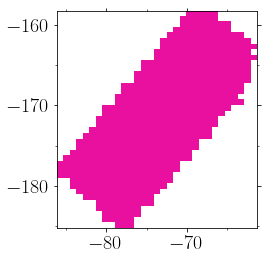

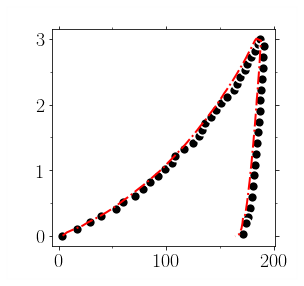

grain_indx= 1000 mse= 2.0892309302604937 area= 71.49791


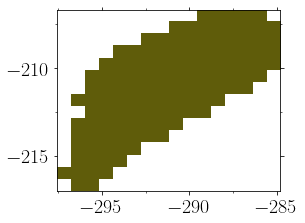

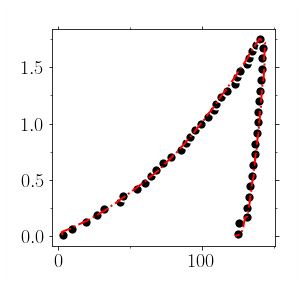

grain_indx= 868 mse= 2.310415473987789 area= 580.8513


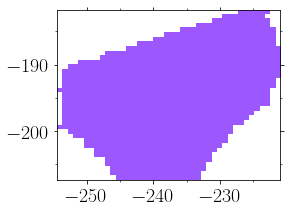

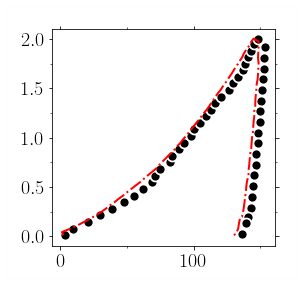

grain_indx= 687 mse= 2.6285359425085364 area= 454.4829


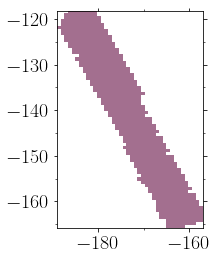

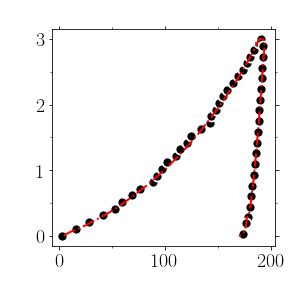

In [46]:
if not eval(confParser['flags']['remote_machine']):
    msee = (np.array(target_nodes_np)-np.array(best_output)).var(axis=1)
    #--- top 5% in mse
    s=list(zip(msee[test_mask_np],np.arange(0,msee.shape[0])[test_mask_np]))
    s.sort(reverse=False)
    s=np.array(s)
    n=s.shape[0]
    #--- different quantiles
    qmin=0#0.9
    qmax=0.11#1.0
    indices = list(map(int,s[int(qmin*n):int(qmax*n)][:,1]))
    #--- filter: mse and area
    # indices = np.arange(len(msee))[np.all([msee < 4, 
    #                                        test_data_grains['area'] > 1e3,
    #                                       test_mask_np
    #                                       ],axis=0)]
    # indices = np.arange(len(msee))[np.all([msee > 30, 
    #                                        msee < 50,
    #                                        test_data_grains['area'] < 100,
    #                                       test_mask_np
    #                                       ],axis=0)]
    print(indices)
    #
    Plott(indices,test_mask_np,best_output,
    #      'smallGrain_hiMSE',
          '10percent_loMSE'
         )

### scatter plot: mse vs. grain size

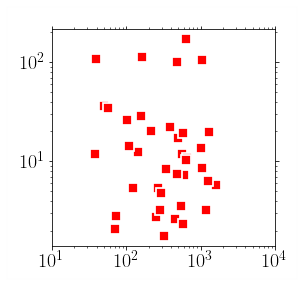

In [47]:
if not eval(confParser['flags']['remote_machine']):
    msee = (np.array(target_nodes_np)-np.array(best_output)).var(axis=1)
    #
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

    ax = utl.PltErr(None,None,Plot=False)


#     utl.PltErr(test_data_grains[train_mask_np]['area'],msee[train_mask_np],
#                ax=ax,
#                attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$',fmt='.'),
#                Plot=False)
    utl.PltErr(test_data_grains[test_mask_np]['area'],msee[test_mask_np],
                attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$',fmt='.'),
               ax=ax,Plot=False)

    utl.PltErr(None, None,
               attrs={'fmt':'-.','color':'C0'},
               yscale='log',
               xscale='log',
#               legend=legend.Get(),
               title = 'mse/mse_grainSize_test_scatter.png',
#               ylim=(1,1e3),
               xlim=(10,1e4),
#               ylim=(0,6),xlim=(0,6),
#                xticks=(['$0$','$2$','$4$','$6$','$8$'],
#                        [0,2,4,6,8]),
               Plot=False,
               DrawFrame=(0.2,0.1,0.15,0.1,0.01),
               ax=ax)




In [48]:
#(utl.Zscore(test_data_grains[train_mask_np]['grainSize'])*utl.Zscore(msee[train_mask_np])).mean()

In [49]:
#(utl.Zscore(test_data_grains[test_mask_np]['grainSize'])*utl.Zscore(msee[test_mask_np])).mean()

test set: actual
test set: prediction


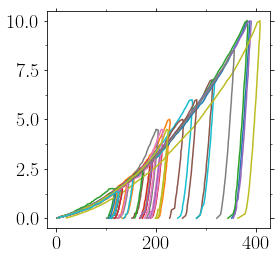

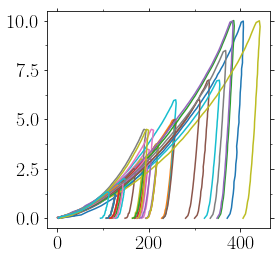

In [50]:
if not eval(confParser['flags']['remote_machine']):
    print('test set: actual')
    ax=utl.PltErr(None,None,Plot=False)
    for grain_indx in range(len(target_nodes_np)):
        if not test_mask_np[grain_indx]:
            continue

        utl.PltErr(
                   target_nodes_np[grain_indx], 
                    forces[grain_indx],
    #               best_output[grain_indx],
                   attrs={'fmt':'-'},
        #            xlim=(xmin,xmax),
        #           ylim=(xmin,xmax),
        #           title = 'png/hardness.png',
    #                xstr='disp',
    #                ystr='load',
                   ax=ax,
                                   Plot=False,

                  )

    print('test set: prediction')
    ax=utl.PltErr(None,None,Plot=False)
    for grain_indx in range(len(target_nodes_np)):
        if not test_mask_np[grain_indx]:
            continue

        utl.PltErr(
                   best_output[grain_indx],
                            forces[grain_indx],

                   attrs={'fmt':'-'},
        #            xlim=(xmin,xmax),
        #           ylim=(xmin,xmax),
        #           title = 'png/hardness.png',
    #                xstr='disp',
    #                ystr='load',
                   ax=ax,
                                   Plot=False,

                  )

# predict hardness

In [51]:
class Hardness(PlotGrains):
    '''
    compute and return hardness
    arguments:
        best_output     - ML prediction
        target_nodes_np - target vector
        test_mask_np    - test set
    '''
    
    def __init__(self,target_nodes_np,
                 train_mask_np,
                 test_mask_np,
                 best_output,
                 id_matrix
                ):
        self.target_nodes_np = target_nodes_np
        self.test_mask_np = test_mask_np
        self.train_mask_np = train_mask_np
        self.best_output = best_output
        
        PlotGrains.__init__(self,id_matrix)
        pass

    
    def GetMaxForce(self,confParser):
        '''
        return max force in LD curves
        '''
        test_data_file_path = confParser['test data files']['test_data_file_path']
        test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
        test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
                                                 test_data_file_path2nd
                                                )
        ngrains = test_data_grains.shape[0]


        #--- prescribed range for displacements 

        #--- loop over indented grains
        TestData.ld_curve = {}
        TestData.load = {}
        for fp,count in zip(finder.files,range(len(finder.files))): 
            test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path']+'/ldGrainID',fp),
                             path_gb=confParser['test data files']['test_data_file_path'],
                             verbose=False,
                            )
            test_data.Parse()
        #    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
        #        continue
            try:
                GrainIndex = test_data.GetGrainIndex()
            except:
                continue
            #--- 1.0e-9 and 1.0e-3: get si units
            #--- assemble feature matrix: append displacements and forces
            TestData.Append(GrainIndex,[test_data.data[:,0].max()],[test_data.data[:,1].max()]) 

        #--- predictors are the displacements
        predictors = TestData.BuildFeature(TestData.ld_curve, 
                                           ngrains,
                                           1
                                          )
        
        

        #---- forces
        self.forces2 = TestData.BuildFeature(TestData.load, 
                                           ngrains,
                                           1
                                          )

    def GetH(self,
             disp,
             forces,
             mask,
             test_data_grains,
             verbose=True):
        '''
        return hardness
        '''
        mean_force_array = np.mean(forces[~np.any(np.isnan(forces),axis=1)],axis=0) #--- replace missing data by the average
        fmax = np.mean(self.forces2[~np.isnan(self.forces2)])
        isnan = np.any(np.isnan(forces),axis=1)
        
        h_pred = []
        indx = []
        ids = []
        self.mask=mask
        for grain_indx in range(len(disp)):
            if not mask[grain_indx]:
                continue
            if verbose:
                print('grain_indx=',grain_indx)

            #--- scale by max force
            disp_pred   = np.array(disp[grain_indx])#kam * \
#            (self.forces2[grain_indx] if not isnan[grain_indx] else fmax) 

            force = (forces[grain_indx] if not isnan[grain_indx] else mean_force_array) #kam *\
            #(self.forces2[grain_indx] if not isnan[grain_indx] else fmax)

            ld_pred=pd.DataFrame(np.c_[range(disp_pred.shape[0]),1.0e-9*disp_pred, 1.0e-3*force],
                            columns=['Time','Depth','Force'])
            try:
                h_pred += [1.0e-9*self.MeasureHardness(ld_pred,Plot=False,verbose=verbose)]
                indx += [grain_indx]
                ids += [test_data_grains['#grainID'].iloc[grain_indx]]
            except:
#                traceback.print_exc()
                if verbose:
                    utl.PltErr(ld_pred.Depth,ld_pred.Force,
                               xstr=r'Depth(nm)',
                               ystr=r'Load(mN)',
                              )


                    print('grain_indx=%s:could not infer hardness!'%grain_indx)
                continue

        return pd.DataFrame(np.c_[ids,h_pred],columns=['#grainID','h(Gpa)'])

    def func(self,x,a,b):
            return a * x + b

    def MeasureHardness(self,ld,Plot=False,verbose=False):
        '''
        calculate hardness
        '''
        pmax = ld.Force.max()
        tunload = ld.Time[ld.Force>=pmax].iloc[-1]
        dt = 0.4 * tunload
        filtr = np.all([ld.Time>tunload,ld.Time<tunload+dt],axis=0)
        z = np.polyfit(ld.Depth[filtr],ld.Force[filtr],deg=1)
        if Plot:
            utl.PltErr(ld.Time[filtr],ld.Force[filtr],
                      xstr=r'Time(s)',
                       ystr=r'Load(mN)',
                      )

            utl.PltErr(ld.Time[filtr],ld.Depth[filtr],
                       xstr=r'Time(s)',
                       ystr=r'Depth(nm)',
                      )

            ax=utl.PltErr(ld.Depth,ld.Force,
                         Plot=False,
                         )
#            utl.PltErr(ld.Depth,self.func(ld.Depth,*z),
#                       fmt='-.r',
#                       label=r'$s=%3.2f$'%z[0],
#                        legend = True,
#                       ax=ax,
#                       xstr=r'Depth(nm)',
#                       ystr=r'Load(mN)',
#                       xlim=(hlo,hhi),
#                      )

            ax=utl.PltErr(ld.Depth[filtr],ld.Force[filtr],
                         Plot=False,
                         )
#            utl.PltErr(ld.Depth[filtr],func(ld.Depth[filtr],*z),
#                       fmt='-.r',
#                       label=r'$s=%3.2f$'%z[0],
#                       legend = True,
#                       ax=ax,
#                       xstr=r'Depth(nm)',
#                       ystr=r'Load(mN)',
#                      )

        pmax = ld.Force.max()#*1e-3 #--- mN
        hmax = ld.Depth.max()#*1e-9 #--- nm
        slope=z[0] #*1e-3/1e-9
        hs = 0.72 * pmax / slope
        hc = hmax - hs
        area = 24.5 * hc * hc 

        hardness = pmax / area
        if verbose:
            print('hardness=%3.2f Gpa'%(1e-9*hardness))

        return hardness

    def Plot(self,h_pred,h_actual,**kwargs):
        xmin,xmax=np.min(h_actual['h(Gpa)']),np.max(h_actual['h(Gpa)'])
        ymin,ymax=np.min(h_pred['h(Gpa)']),np.max(h_pred['h(Gpa)'])
        minn=.9*np.min([xmin,ymin]) if not 'minn' in kwargs else kwargs['minn']
        maxx=1.1*np.max([xmax,ymax]) if not 'maxx' in kwargs else kwargs['maxx']
        ax=utl.PltErr([minn,maxx],[minn,maxx],Plot=False,
                      attrs={'fmt':'-.r'}
                     )
        utl.PltErr(np.array(h_actual['h(Gpa)']),
                  np.array(h_pred['h(Gpa)']),
                   attrs={'fmt':'x','markersize':12},
                   xlim=(minn,maxx),
                   ylim=(minn,maxx),
                   xstr='actual',
                   ystr='prediction',
                   ax=ax,
                   **kwargs
                  )
        self.mse = mean_squared_error(h_actual['h(Gpa)'],h_pred['h(Gpa)'])
        #np.savetxt('mse/mse.txt',np.c_[mean_squared_error(h_actual,h_pred)],header='mse')
        print('mse=',self.mse)
        return (minn,maxx)
        
        
    def Bitmap(self,test_data_grains,h,**kwargs):
        self.reshape( np.c_[h['#grainID']],np.c_[h['h(Gpa)']])
        self.Bounds(np.c_[test_data_grains[['x','y']]])
        self.Transform()
        self.TransformField()
        grainID_notindented = np.c_[test_data_grains['#grainID'][~self.mask]]
        self.MaskField(grainID_notindented)
        self.Mask(grainID_notindented)
        self.PlotField(mask = self.id_matrix.T == 0,**kwargs)




## h_act

open and load data from test_data.csv complete.
actual


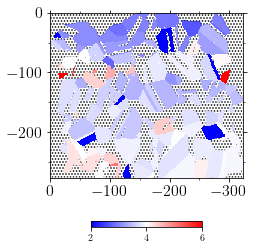

In [112]:
#hardness map
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
# h_pred = hard.GetH(
#             best_output, #--- predicted disp
#             forces, #--- force vector
#           np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
#           test_data_grains, #--- grain properties
#           verbose=False)

# limits = hard.Plot(h_pred,h_actual,
#                   title='png/scatterPlotValidation.png',
#                   )
# dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)']/h_actual['h(Gpa)']-1).abs()],
#                 columns=['#grainID','h(Gpa)'])
print('actual')
hard.Bitmap(test_data_grains,
            h_actual,
            vminmax=(2.0,6),#limits,
#            vminmax=(0.0,8),#limits,
            cmap=['jet','gray','rainbow','seismic','bwr'][4],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
            title='png/actual_hmap.png',
            pad=0.2,
            fontsize=16,
           )



## scatter plot: test

open and load data from test_data.csv complete.


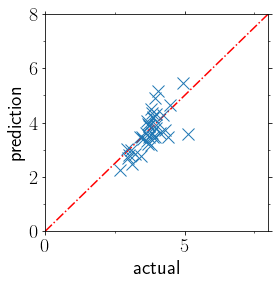

mse= 0.257726493454682
prediction


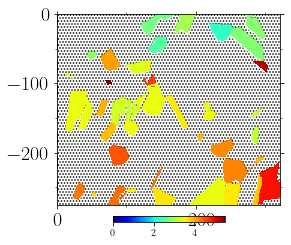

0.257726493454682

In [53]:
def GetMseHardness(best_output,filtr,title='mse/scatter_test.txt',Plot=False):
    #--- test data
    hard = Hardness(target_nodes_np,
                    train_mask_np,
                    test_mask_np,
                    best_output,
                    np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) 
                   )
    hard.GetMaxForce(confParser)
    h_actual = hard.GetH(
                target_nodes_np, #--- actual disp
                forces, #--- force vector
              filtr, #--- filter grains: test set
              test_data_grains, #--- grain properties
              verbose=False)
    h_pred = hard.GetH(
                best_output, #--- predicted disp
                forces, #--- force vector
              filtr,
              test_data_grains, #--- grain properties
              verbose=False)
    #--- scatter plot
    limits = hard.Plot(h_pred,h_actual,
    #                  title='png/scatterPlotValidation.png',
                       minn=0.0,maxx=8.0,
                      )
    np.savetxt(title,np.c_[h_pred['h(Gpa)'],h_actual['h(Gpa)']],header='prediction\tactual')

    dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)'])],
                    columns=['#grainID','h(Gpa)'])
    print('prediction')
    if Plot:
        hard.Bitmap(test_data_grains,
                dh,
    #            vminmax=limits,
                cmap=['jet','gray','rainbow','seismic','bwr'][0],
    #            fracy=(-100,0),
                orientation='horizontal',
                interpolation='none',
    #            title='png/validation.png'
               )
    
    return np.mean((h_actual['h(Gpa)']-h_pred['h(Gpa)'])**2)


GetMseHardness(best_output,test_mask_np,'mse/scatter_test.txt',Plot=True)

## scatter plot: train

open and load data from test_data.csv complete.


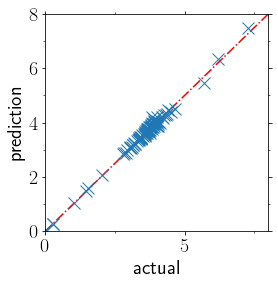

mse= 0.00873810516290523
prediction


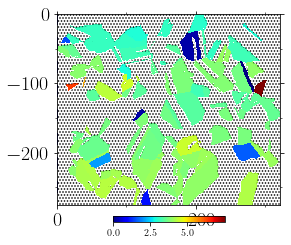

0.00873810516290523

In [54]:
# def main(best_output,title='mse/scatter_train.txt'):
#     #--- test data
#     hard = Hardness(target_nodes_np,
#                     train_mask_np,
#                     test_mask_np,
#                     best_output,
#                     np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) 
#                    )
#     hard.GetMaxForce(confParser)
#     h_actual = hard.GetH(
#                 target_nodes_np, #--- actual disp
#                 forces, #--- force vector
#               train_mask_np, #--- filter grains: train set
#               test_data_grains, #--- grain properties
#               verbose=False)
#     h_pred = hard.GetH(
#                 best_output, #--- predicted disp
#                 forces, #--- force vector
#               train_mask_np,
#               test_data_grains, #--- grain properties
#               verbose=False)
#     #--- scatter plot
#     limits = hard.Plot(h_pred,h_actual,
#     #                  title='png/scatterPlotValidation.png',
#                        minn=2.0,maxx=6.0,
#                       )
#     np.savetxt(title,np.c_[h_pred['h(Gpa)'],h_actual['h(Gpa)']],header='prediction\tactual')

#     dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)'])],
#                     columns=['#grainID','h(Gpa)'])
#     print('prediction')
#     hard.Bitmap(test_data_grains,
#                 dh,
#     #            vminmax=limits,
#                 cmap=['jet','gray','rainbow','seismic','bwr'][0],
#     #            fracy=(-100,0),
#                 orientation='horizontal',
#                 interpolation='none',
#     #            title='png/validation.png'
#                )

GetMseHardness(best_output,train_mask_np,'mse/scatter_train.txt',Plot=True)
#GetMseHardness(best_output,train_mask_np,'mse/scatter_train_noedge.txt')
# GetMseHardness(ypred_linreg,train_mask_np,'mse/scatter_train_linreg.txt')
# GetMseHardness(ypred_knn,train_mask_np,'mse/scatter_train_knn.txt')

## full map

open and load data from test_data.csv complete.
prediction


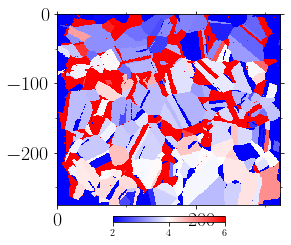

In [55]:
#--- test data
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) 
               )
hard.GetMaxForce(confParser)

h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          np.ones(1082,dtype=bool),
          test_data_grains, #--- grain properties
          verbose=False)
#--- scatter plot
# limits = hard.Plot(h_pred,h_actual,
# #                  title='png/scatterPlotValidation.png',
#                    minn=2.0,maxx=6.0,
#                   )
# np.savetxt('mse/scatter_train.txt',np.c_[h_pred['h(Gpa)'],h_actual['h(Gpa)']],header='prediction\tactual')

dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)'])],
                columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            dh,
            vminmax=(2,6),
            cmap=['jet','gray','rainbow','seismic','bwr'][4],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
#            title='png/validation.png'
           )





## plot scatter data

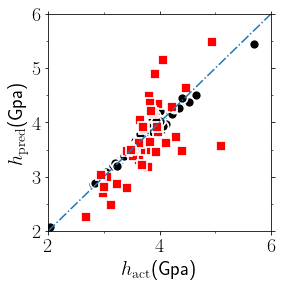

In [120]:
if not eval(confParser['flags']['remote_machine']):
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

    ax = utl.PltErr(None,None,Plot=False)

    h_train = np.loadtxt('mse/scatter_train.txt')
    h_test = np.loadtxt('mse/scatter_test.txt')

    utl.PltErr(h_train[:,1],h_train[:,0],
               ax=ax,
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$',fmt='.'),
               Plot=False)
    utl.PltErr(h_test[:,1],h_test[:,0],
                attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$',fmt='.'),
               ax=ax,Plot=False)

    utl.PltErr([2,6],[2,6],
               attrs={'fmt':'-.','color':'C0'},
#               yscale='log',
#               legend=legend.Get(),
               title = 'mse/validation_scatter.png',
               ylim=(2,6),xlim=(2,6),
               xticks=(['$2$','$4$','$6$'],
                       [2,4,6]),
               xstr='$h_\mathrm{act}$(Gpa)',ystr='$h_\mathrm{pred}$(Gpa)',
               Plot=False,
               ax=ax)

In [57]:
np.mean(utl.Zscore(h_train[:,1])*utl.Zscore(h_train[:,0]))

0.9958689403156736

In [58]:
np.mean(utl.Zscore(h_test[:,1])*utl.Zscore(h_test[:,0]))

0.6949455554119938

In [59]:
filterr=h_test[:,0]<6
np.mean(utl.Zscore(h_test[:,1][filterr])*utl.Zscore(h_test[:,0][filterr]))

0.6949455554119938

## h_act-h_pred

open and load data from test_data.csv complete.


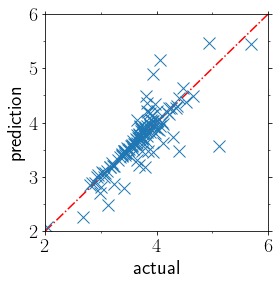

mse= 0.08343462165043825
prediction


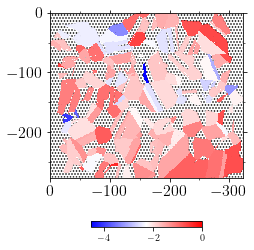

In [116]:
#hardness map
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
# h_actual = hard.GetH(
#             target_nodes_np, #--- actual disp
#             forces, #--- force vector
#           np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
#           test_data_grains, #--- grain properties
#           verbose=False)

limits = hard.Plot(h_pred,h_actual,
                  title='png/scatterPlotValidation.png',
                   minn=2.0,maxx=6.0,
                  )
# dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)']/h_actual['h(Gpa)']-1).abs()],
#                 columns=['#grainID','h(Gpa)'])
dh=pd.DataFrame(np.c_[h_pred['#grainID'],np.log10(np.abs((h_pred['h(Gpa)']-h_actual['h(Gpa)'])/h_pred['h(Gpa)']))],
                columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            dh,
#            vminmax=(0,1),#(-3,3),#(dh['h(Gpa)'].min(),dh['h(Gpa)'].max()),
            cmap=['jet','gray','rainbow','seismic','bwr'][4],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
            title='png/dh.png',
            pad=0.2,
            fontsize=16,
           )





## h_pred

open and load data from test_data.csv complete.


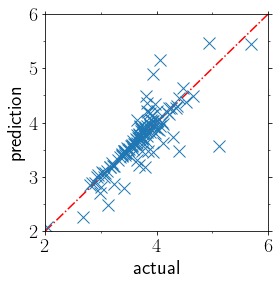

mse= 0.08343462165043825
prediction


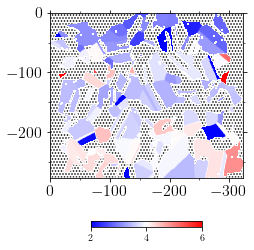

In [113]:
#hardness map
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/id_matrix.txt'%confParser['test data files']['ebsd_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)

limits = hard.Plot(h_pred,h_actual,
                  title='png/scatterPlotValidation.png',
                   minn=2.0,maxx=6.0,
                  )
# dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)']/h_actual['h(Gpa)']-1).abs()],
#                 columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            h_pred,
            vminmax=(2.0,6),#limits,
            cmap=['jet','gray','rainbow','seismic','bwr'][4],
#            fracy=(-100,0),
            orientation='horizontal',
#            interpolation='bilinear',
            title='png/predicted_hmap.png',
            pad=0.2,
            fontsize=16,
           )





# classical models

In [62]:
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_validate

class MachineLearning:
    '''
    wrapper for sklearn ml libraries
    '''
    
    def __init__(self, confParser):
        '''
        class constructor
        '''
        self.confParser = confParser

    def split_training_test(self,box):
        '''
        train-test split
        '''
        CellVector_train = box.CellVector.copy()
        CellVector_train[0,0] *= 0.7 
        box_train = lp.Box(CellOrigin=box.CellOrigin,CellVector=CellVector_train)

        #--- filter interior atoms
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime0].to_dict(orient='series') )
        wrap = lp.Wrap( atoms, box_train )
        self.filtr_train = wrap.isInside()
        print('# of atoms in the train set :',np.sum(self.filtr_train))

    #     PrintOvito( pd.DataFrame(atoms.__dict__)[filtr_train], 
    #                  open( 'xyz_actual.xyz','a'), 
    #                  footer = 'ITIME=%s'%itime,
    #                  attr_list=['id','type','x','y','z'])

   
    def parhinello(self,df):
        '''
        returns structure function
        '''
        #--- structure function
        if eval(self.confParser['ml flags']['ReadDisc']):
            return
        #--- radial
        sigma=eval(self.confParser['ml flags']['sigma'])
        rstart = eval(self.confParser['ml flags']['rstart'])
        cutoff = eval(self.confParser['neighbor list']['cutoff'])
        rbars = np.arange(rstart,cutoff,sigma)
        print('num(radial features)=%s'%(len(rbars)))
        t0=time.time()    
        structFuncRad = np.array(list(map(lambda x:self.GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
        print('radial struct t=%s s'%(time.time()-t0))
        print('structFuncRad.shape=',structFuncRad.shape)
        return structFuncRad
#        assert structFuncRad.shape[0] == len(d2min.x), 'some atoms have no neighbors!'

        #--- angular
        if eval(self.confParser['ml flags']['StructFuncAng']):
            cutoffAng = 4.5 #--- 2nd peak
            #--- filter df: decrease cutoff distance for the anglular analysis
            df_filtrd = df[df['DIST']<cutoffAng]
            df_filtrd.reset_index(drop=True,inplace=True)
            #---
            t0=time.time()
    #         pdb.set_trace()
            angst = lp.AngularStruct(df_filtrd)
            angst.GetDistAngle()
            print('assemble triplets t=%s s'%(time.time()-t0))
            #--- set params. list
            deltas = np.arange(rstart,cutoffAng,3.0*sigma)
            b=np.array([1.0,-1.0])
            c=np.array([0.5,1.0,2.0])
            #
            xx, yy, zz = np.meshgrid(deltas,b,c)
            plist = list(zip(xx.flatten(),yy.flatten(),zz.flatten()))
            print('num(ang. features)=%s'%(len(plist)))
            #
            t0=time.time()    
            structFuncAng = np.array(list(map(lambda x: angst.Get(*x),plist))).T
            print('apply parameters t=%s s'%(time.time()-t0))
            print('structFuncAng.shape=',structFuncAng.shape)
            return structFuncAng

    def GetAttribute(self,df,rbar,sigma):
        '''
        auxiliary fuction
        '''
        sigma2=sigma*sigma
        rho=df.apply(lambda x: np.exp(-0.5*(x.DIST-rbar)**2/sigma2),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
        #---
        tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
        tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
        return np.array(tmp_sum)
    
    def assemble(self,train_mask,test_mask,X):
        '''
        set feature matrix
        '''
#         if not eval(self.confParser['ml flags']['ReadDisc']):
#             X=np.c_[structFuncRad,structFuncAng] if eval(self.confParser['ml flags']['StructFuncAng'])\
#             else np.c_[structFuncRad]
#             if eval(self.confParser['ml flags']['WritDisc']):
#                 with open('MlAnl/features.npy','wb') as f:
#                     np.save( f, X )
#         else:
#             with open('MlAnl/features.npy','rb') as f:
#                 X = np.load(f)
#         print('X.shape=',X.shape)
        self.X_train = X[ train_mask ]
        self.X_test  = X[ test_mask ]

    def Predictors(self,y):
        '''
        set predictors
        '''
            #--- voronoi data
        #     filtr = lmpVor.coord_atoms_broken[itime0]['id'] < natoms #--- current frame
        #     vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime0][filtr].to_dict(orient='series') )
        #     icoFilter = GetFullIcosahedra( vor )

            #--- d2min    

        #    filtr = lmpDmin.coord_atoms_broken[itime]['id'] <= natoms

            #--- predictors
#             threshold = [
#         #                 mu_divide,
#                          GetQuantile(np.log10(d2min.d2min),0.52),
#                          GetQuantile(np.log10(d2min.d2min),0.9),
#                          np.mean(np.log10(d2min.d2min)) + np.std(np.log10(d2min.d2min))
#                         ][1]

        self.y_train = {
        #            '0':np.c_[np.log10(d2min.d2min)[filtr_train] <= threshold ],
        #        '0':np.c_[np.sum(X,axis=1)[filtr_train]  < 173.0],
        #            '1':np.c_[icoFilter],
        #            '0':np.c_[d2min.type[filtr_train]<=1]
                    0:np.c_[y[self.filtr_train]]
                }[0]

        self.y_test = {
        #            '0':np.c_[np.log10(d2min.d2min)[~filtr_train] <= threshold ],
        #            '0':np.c_[d2min.type[~filtr_train]<=1]
        #        '0':np.c_[np.sum(X,axis=1)[~filtr_train] < 173.0],
                    0:np.c_[y[self.filtr_test]]
                }[0]
            
    def kNN(self):
        #-----------------------
        #--- train and validate
        #-----------------------
        t0 = time.time()
        param_grid = {'n_neighbors':np.logspace(0,10,11,base=2).astype(int)} #np.arange(1,100,4)} #
        knn = KNeighborsClassifier()
        clf = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_log_error')
        clf.fit(self.X_train,self.y_train)
        print('training elapsed time:%ss'%(time.time()-t0))
        print('mean_test_score=',-clf.cv_results_['mean_test_score'])
        print('n_neighbors=%s'%(clf.best_estimator_.n_neighbors))

    def kNNregressor(self):
        #-----------------------
        #--- train and validate
        #-----------------------
        t0 = time.time()
        param_grid = {'n_neighbors':np.logspace(0,10,11,base=2).astype(int)} #np.arange(1,100,4)} #
        knn = KNeighborsRegressor()
        clf = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_log_error')
        clf.fit(self.X_train,self.y_train)
        print('training elapsed time:%ss'%(time.time()-t0))
        print('mean_test_score=',-clf.cv_results_['mean_test_score'])
        print('n_neighbors=%s'%(clf.best_estimator_.n_neighbors))

            
    def svc(self,verbose=False):
        #-----------------------
        #--- train and validate
        #-----------------------
        t0 = time.time()
        param_grid = {
                       'gamma':['auto'], #--- don't change
                      'kernel':['rbf'],
                      'tol':[1.0e-6],
    #                 'C':[1,10.0,1000.0], #np.logspace(0,9,10,base=2)
                     } 
    #     svc = SVC(probability=False,
    #               random_state=0,
    #               verbose=True,
    #              )
        svc = SVR(
                  verbose=verbose,
    #              shrinking=False,
                 )
        clf = GridSearchCV(svc, 
                           param_grid, 
                           scoring='neg_mean_squared_log_error',
    #                       cv = 2,
                          )
        clf.fit(self.X_train,self.y_train)
        print('training elapsed time:%ss'%(time.time()-t0))
        print('mean_test_score=',-clf.cv_results_['mean_test_score'])
        
        self.y_pred = clf.best_estimator_.predict(self.X_test)
        self.y_true = self.y_test

            
    def confusion_matrix(self):
        '''
        return confusion matrix
        '''
        cm = confusion_matrix(self.y_true, self.y_pred,
                         labels=[True, False]
                        )
        print('cm=',cm)
#             with open('MlAnl/y_true_pred.txt','w') as fp:
#                 np.savetxt(fp,np.c_[y_true.flatten(),y_pred.flatten()].astype(int),fmt='%d',header='y_true\ty_pred')
#             with open('MlAnl/confusion_matrix.txt','w') as fp:
#                 np.savetxt(fp,np.c_[cm],header='confusion_matrix',fmt='%d')


    def DimReduction(self, Plot=False):
        '''
        dimensionality reduction
        '''
        t0=time.time()
        #--- pipeline
        DimReduc = make_pipeline( 
                                  StandardScaler(),
                                  TSNE(n_components=2,random_state=0),
    #                              PCA(n_components=3, random_state=0),

                                )
        DimReduc.fit(self.X_train)
        X_embedded = DimReduc.fit_transform(self.X_train)
        print('dim. reduction t=%s s'%(time.time()-t0))
        
        if Plot:
            color=np.array(['C0']*len(self.y_train))
            color[(self.y_train==False).flatten()]='r' #--- rearranging atoms
            #
        #    color=np.array(['C0']*len(y['2']))
        #    color[(y_train['2']==1).flatten()]='r'


            utl.PltScatter(Zscore(X_embedded[:,0]),Zscore(X_embedded[:,1]),
                           attrs={'s':10,'c':color,'alpha':0.4},
                           xstr=r'$\hat{G}_i^1$',
                           ystr=r'$\hat{G}_i^2$',
                           title='MlAnl/tsne.png'
                          )

        #     PrintOvito( pd.DataFrame(np.c_[X_embedded,y['0']],columns=['x','y','z','type']), 
        #                  open( 'MlAnl/sne_ovito.xyz','w'), 
        #                  footer = 'ITIME=%s'%itime,
        #                  attr_list=['x','y','z','type'] )



        return X_embedded
    
    def Plot_predictions(self):
        '''
        Plot
        '''
        
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], AddMissing = np.array([0.0,0.0,0.0] ))

        PlotAttrs = {
    #                'scale' : 'log',
                    'xlabel' : '', #r'$x$(\r{A})', 
                    'ylabel' : '', #r'$y$(\r{A})',
    #                'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
                    'colorbar':True,
                    'labels' : True,
    #                'vmin':-0.5,
    #                'vmax':+2.1,
                    'fontsize':18,
                    'interpolation':'bilinear',
                    }

        junk, junk, d2intrp = Intrp(d2min, box0,
                        attr = 'd2min',
                        Plot = True,
                        title='D2minAnl/map_d2min.png',
                        zscore=True,
                        **PlotAttrs
                        )

        y_pred = clf.best_estimator_.predict(X)
        d2min.tmp= {0:y_pred == False,
    #               1:np.all([y_true.flatten()==False,y_pred.flatten()==False],axis=0),
    #               2:clf.predict_proba(X)[:,1],
                   }[0] #--- mobile
        junk, junk, d2intrp = Intrp(d2min, box0,
                        attr = 'tmp',
                        Plot = True,
                        title='D2minAnl/map_d2min_pred.png',
                        zscore=False,
                        **PlotAttrs
                        )


In [63]:
    
    #--- ml instance
    ml = MachineLearning(confParser)
    
    #--- structure function
    #--- neighbor list
#    itime0 = eval(confParser['parameters']['itime0'])
#    neighList = lmpNeigh.coord_atoms_broken[itime0]
    #
#    structFuncRad = ml.parhinello(neighList)

    #--- train-test split
#    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
#                 AddMissing = np.array([0.0,0.0,0.0] ))
#    ml.split_training_test(box)
    if eval(confParser['Parameters']['split_type']) == 0: 
        tsp.train_test_split()
    elif eval(confParser['Parameters']['split_type']) == 1: 
        tsp.train_test_split_structured(np.c_[test_data_grains[['x','y']]])
    
    #--- feature matrix
    X = np.array(static_graph_tr['nodes'])
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    
    ml.assemble(tsp.train_mask,tsp.test_mask,X)

    
    #--- dimensionality reduction
#    ml.DimReduction()
    
    #--- predictors
#    itime = eval(confParser['parameters']['itime'])
#    d2min = np.log10(lmpDmin.coord_atoms_broken[itime].d2min)
    ml.filtr_train = tsp.train_mask
    ml.filtr_test = tsp.test_mask
    y = np.array(target_nodes_np)
    ml.Predictors(y)
    
    #--- train
#    ml.kNNregressor()

## knn

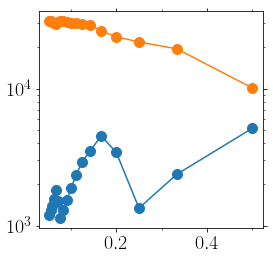

<AxesSubplot:>

In [108]:
mse = {}
mse_train = {}
N_neighbors = np.arange(2,20)
mse_test_knn=np.zeros(len(N_neighbors))
mse_train_knn=np.zeros(len(N_neighbors))
for n_neighbors,indx in zip(N_neighbors,range(len(mse_test_knn))): 
    knn = KNeighborsRegressor(n_neighbors=n_neighbors,p=1, weights='uniform')
    knn.fit(ml.X_train,ml.y_train)
    ypred = knn.predict(ml.X_test)
    mse[n_neighbors] = mean_squared_error(ypred,ml.y_test)
    mse_train[n_neighbors] = mean_squared_error(knn.predict(ml.X_train),ml.y_train)
    #--- mse
    mse_test_knn[indx] = mean_squared_error(ypred,ml.y_test) #GetMseHardness(knn.predict(X),test_mask_np,'mse/junk.txt')
    mse_train_knn[indx] = mean_squared_error(knn.predict(ml.X_train),ml.y_train) #GetMseHardness(knn.predict(X),train_mask_np,'mse/junk.txt')

ax=utl.PltErr(1/N_neighbors,[mse[i] for i in N_neighbors],Plot=False)
utl.PltErr(1/N_neighbors,[mse_train[i] for i in N_neighbors],ax=ax,yscale='log')

#--- best model
# nmin = min([[mse[i],i] for i in N_neighbors])[1]

# #--- best output
# knn = KNeighborsRegressor(n_neighbors=nmin)
# knn.fit(ml.X_train,ml.y_train)
# ypred_knn = knn.predict(X)


## linear regression

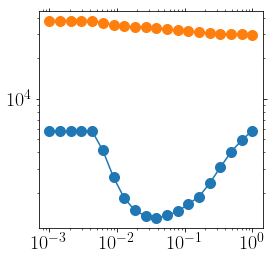

<AxesSubplot:>

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

mse = {}
mse_train = {}
Alpha = np.logspace(0,3,20)
mse_test_linreg = np.zeros(len(Alpha))
mse_train_linreg = np.zeros(len(Alpha))
for alpha,indx in zip(Alpha,range(len(mse_test_linreg))): 
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(ml.X_train,ml.y_train)
    #print('mean_test_score=',-clf.cv_results_['mean_test_score'])
    #print('n_neighbors=%s'%(clf.best_estimator_.n_neighbors))
    ypred = reg.predict(ml.X_test)
    mse[alpha] = mean_squared_error(ypred,ml.y_test)
    mse_train[alpha] = mean_squared_error(reg.predict(ml.X_train),ml.y_train)

    mse_test_linreg[indx] = mean_squared_error(ypred,ml.y_test) #GetMseHardness(reg.predict(X),test_mask_np,'mse/junk.txt')
    mse_train_linreg[indx] = mean_squared_error(reg.predict(ml.X_train),ml.y_train) #GetMseHardness(reg.predict(X),train_mask_np,'mse/junk.txt')

ax=utl.PltErr(1/Alpha,[mse[i] for i in Alpha],
          Plot=False)
utl.PltErr(1/Alpha,[mse_train[i] for i in Alpha],
          xscale='log',ax=ax,yscale='log')

# #--- best model
# alpha = min([[mse[i],i] for i in Alpha])[1]

# #--- best output
# reg = linear_model.Lasso(alpha=alpha)
# reg.fit(ml.X_train,ml.y_train)
# ypred_linreg = reg.predict(X)


## gnn no edge

In [66]:
if eval(confParser['flags']['train_test']):
    #--- graph without edges
    if eval(confParser['flags']['without_edges']): 
    #     static_graph_tr.pop('edges')
    #     static_graph_tr.pop('receivers')
    #     static_graph_tr.pop('senders')
        static_graph_tr['edges']=[static_graph_tr['edges'][0]]
        static_graph_tr['receivers']=[static_graph_tr['receivers'][0]]
        static_graph_tr['senders']=[static_graph_tr['senders'][0]]

    input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
    graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
    #print(input_graph)
    print('nodes matrix shape:',np.array(static_graph_tr['nodes']).shape)
    if not eval(confParser['flags']['without_edges']): 
        print('edge matrix shape:',np.array(static_graph_tr['edges']).shape)

    
    
    if eval(confParser['Parameters']['split_type']) == 0: 
        tsp.train_test_split()
    elif eval(confParser['Parameters']['split_type']) == 1: 
        tsp.train_test_split_structured(np.c_[test_data_grains[['x','y']]])
    #
    gnnReg = GnnRegressor(
                            num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']),
                            num_training_iterations = eval(confParser['Parameters']['num_training_iterations']), 
                            learning_rate = eval(confParser['Parameters']['learning_rate']),
                            stopping_criterion = eval(confParser['Parameters']['stopping_criterion']),
                            input_graph=input_graph,
                            node_output_size = len(target_nodes_np[0]),
                            train_mask = tf.constant(tsp.train_mask, dtype=tf.bool),
                            test_mask  = tf.constant(tsp.test_mask , dtype=tf.bool),
                            val_mask   = tf.constant(tsp.test_mask  , dtype=tf.bool),
                            target_nodes = tf.constant(target_nodes_np),
                            train_mask_np = tsp.train_mask,
                            test_mask_np  = tsp.test_mask,
                            val_mask_np   = tsp.test_mask,
                            target_nodes_np = target_nodes_np,
                            weight = None )

    gnnReg.fit( np.array(static_graph_tr['nodes'])[tsp.train_mask],
                np.array(target_nodes_np)[tsp.train_mask] )

    best_output_no_edge, _ = gnnReg.predict(np.array(static_graph_tr['nodes']))

    _ = gnnReg.mse(np.array(target_nodes_np)[tsp.test_mask].flatten(),
                np.array(best_output[tsp.test_mask]).flatten())
    _ = gnnReg.mse(np.array(target_nodes_np)[tsp.train_mask].flatten(),
                np.array(best_output[tsp.train_mask]).flatten())


nodes matrix shape: (1082, 112)
Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_1/graph_independent/node_model/node_output/b       100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_1/graph_independent/node_model/node_output/w       8x100  float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/linear_0/w      2x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/gra

700, training 7.02e+04, validation 2.61e+04, test 2.61e+04, best loss 2.76e+04
800, training 6.82e+04, validation 2.45e+04, test 2.45e+04, best loss 2.61e+04
900, training 6.62e+04, validation 2.29e+04, test 2.29e+04, best loss 2.45e+04
1000, training 6.41e+04, validation 2.13e+04, test 2.13e+04, best loss 2.29e+04
1100, training 6.20e+04, validation 1.96e+04, test 1.96e+04, best loss 2.13e+04
1200, training 5.98e+04, validation 1.80e+04, test 1.80e+04, best loss 1.96e+04
1300, training 5.77e+04, validation 1.64e+04, test 1.64e+04, best loss 1.80e+04
1400, training 5.57e+04, validation 1.49e+04, test 1.49e+04, best loss 1.64e+04
1500, training 5.37e+04, validation 1.34e+04, test 1.34e+04, best loss 1.49e+04
1600, training 5.18e+04, validation 1.21e+04, test 1.21e+04, best loss 1.34e+04
1700, training 5.01e+04, validation 1.09e+04, test 1.09e+04, best loss 1.21e+04
1800, training 4.85e+04, validation 9.77e+03, test 9.77e+03, best loss 1.09e+04
1900, training 4.69e+04, validation 8.78e+0

11000, training 8.31e+02, validation 9.63e+02, test 9.63e+02, best loss 6.81e+02
11100, training 7.37e+02, validation 8.24e+02, test 8.24e+02, best loss 6.81e+02
11200, training 6.51e+02, validation 7.22e+02, test 7.22e+02, best loss 6.81e+02
11300, training 5.76e+02, validation 6.73e+02, test 6.73e+02, best loss 6.81e+02
11400, training 5.04e+02, validation 6.76e+02, test 6.76e+02, best loss 6.73e+02
11500, training 4.42e+02, validation 6.98e+02, test 6.98e+02, best loss 6.73e+02
11600, training 3.86e+02, validation 7.25e+02, test 7.25e+02, best loss 6.73e+02
11700, training 3.39e+02, validation 7.28e+02, test 7.28e+02, best loss 6.73e+02
11800, training 2.91e+02, validation 7.41e+02, test 7.41e+02, best loss 6.73e+02
11900, training 2.54e+02, validation 7.26e+02, test 7.26e+02, best loss 6.73e+02
12000, training 2.19e+02, validation 7.28e+02, test 7.28e+02, best loss 6.73e+02
12100, training 1.88e+02, validation 7.05e+02, test 7.05e+02, best loss 6.73e+02
12200, training 1.62e+02, va

21200, training 6.70e+00, validation 2.07e+03, test 2.07e+03, best loss 6.15e+02
21300, training 7.42e+00, validation 1.71e+03, test 1.71e+03, best loss 6.15e+02
21400, training 6.18e+00, validation 2.02e+03, test 2.02e+03, best loss 6.15e+02
21500, training 6.13e+00, validation 1.77e+03, test 1.77e+03, best loss 6.15e+02
21600, training 6.14e+00, validation 1.95e+03, test 1.95e+03, best loss 6.15e+02
21700, training 6.81e+00, validation 1.40e+03, test 1.40e+03, best loss 6.15e+02
21800, training 9.30e+00, validation 1.77e+03, test 1.77e+03, best loss 6.15e+02
21900, training 6.40e+00, validation 1.68e+03, test 1.68e+03, best loss 6.15e+02
22000, training 6.62e+00, validation 1.73e+03, test 1.73e+03, best loss 6.15e+02
22100, training 5.78e+00, validation 1.63e+03, test 1.63e+03, best loss 6.15e+02
22200, training 5.75e+00, validation 1.61e+03, test 1.61e+03, best loss 6.15e+02
22300, training 5.81e+00, validation 1.50e+03, test 1.50e+03, best loss 6.15e+02
22400, training 6.21e+00, va

31400, training 1.37e+01, validation 3.45e+03, test 3.45e+03, best loss 5.40e+02
31500, training 5.64e+00, validation 3.77e+03, test 3.77e+03, best loss 5.40e+02
31600, training 5.58e+00, validation 3.89e+03, test 3.89e+03, best loss 5.40e+02
31700, training 6.33e+00, validation 3.99e+03, test 3.99e+03, best loss 5.40e+02
31800, training 5.54e+00, validation 4.00e+03, test 4.00e+03, best loss 5.40e+02
31900, training 5.80e+00, validation 4.06e+03, test 4.06e+03, best loss 5.40e+02
32000, training 5.64e+03, validation 2.09e+03, test 2.09e+03, best loss 5.40e+02
32100, training 5.43e+03, validation 2.14e+03, test 2.14e+03, best loss 5.40e+02
32200, training 5.02e+03, validation 1.96e+03, test 1.96e+03, best loss 5.40e+02
32300, training 4.47e+03, validation 1.85e+03, test 1.85e+03, best loss 5.40e+02
32400, training 6.60e+02, validation 1.48e+03, test 1.48e+03, best loss 5.40e+02
32500, training 5.03e+02, validation 1.49e+03, test 1.49e+03, best loss 5.40e+02
32600, training 3.97e+02, va

41600, training 1.60e+01, validation 7.55e+03, test 7.55e+03, best loss 5.40e+02
41700, training 1.42e+01, validation 7.54e+03, test 7.54e+03, best loss 5.40e+02
41800, training 2.16e+01, validation 7.30e+03, test 7.30e+03, best loss 5.40e+02
41900, training 1.68e+01, validation 7.36e+03, test 7.36e+03, best loss 5.40e+02
42000, training 1.40e+01, validation 7.74e+03, test 7.74e+03, best loss 5.40e+02
42100, training 1.38e+01, validation 7.82e+03, test 7.82e+03, best loss 5.40e+02
42200, training 1.70e+01, validation 7.77e+03, test 7.77e+03, best loss 5.40e+02
42300, training 1.37e+01, validation 8.05e+03, test 8.05e+03, best loss 5.40e+02
42400, training 1.80e+01, validation 8.10e+03, test 8.10e+03, best loss 5.40e+02
42500, training 1.33e+01, validation 8.20e+03, test 8.20e+03, best loss 5.40e+02
42600, training 1.32e+01, validation 8.35e+03, test 8.35e+03, best loss 5.40e+02
42700, training 1.31e+01, validation 8.46e+03, test 8.46e+03, best loss 5.40e+02
42800, training 1.30e+01, va

51800, training 1.05e+01, validation 7.55e+03, test 7.55e+03, best loss 5.40e+02
51900, training 1.25e+01, validation 7.69e+03, test 7.69e+03, best loss 5.40e+02
52000, training 1.02e+01, validation 7.62e+03, test 7.62e+03, best loss 5.40e+02
52100, training 1.26e+01, validation 7.56e+03, test 7.56e+03, best loss 5.40e+02
52200, training 9.70e+00, validation 7.71e+03, test 7.71e+03, best loss 5.40e+02
52300, training 1.12e+01, validation 7.71e+03, test 7.71e+03, best loss 5.40e+02
52400, training 1.16e+01, validation 7.61e+03, test 7.61e+03, best loss 5.40e+02
52500, training 9.54e+00, validation 7.69e+03, test 7.69e+03, best loss 5.40e+02
52600, training 1.23e+01, validation 7.78e+03, test 7.78e+03, best loss 5.40e+02
52700, training 9.76e+00, validation 7.71e+03, test 7.71e+03, best loss 5.40e+02
52800, training 1.24e+01, validation 7.61e+03, test 7.61e+03, best loss 5.40e+02
52900, training 9.65e+00, validation 7.75e+03, test 7.75e+03, best loss 5.40e+02
53000, training 1.23e+01, va

62000, training 7.43e+00, validation 5.96e+03, test 5.96e+03, best loss 5.40e+02
62100, training 1.26e+01, validation 5.87e+03, test 5.87e+03, best loss 5.40e+02
62200, training 7.13e+00, validation 5.89e+03, test 5.89e+03, best loss 5.40e+02
62300, training 1.06e+01, validation 5.83e+03, test 5.83e+03, best loss 5.40e+02
62400, training 7.26e+00, validation 5.87e+03, test 5.87e+03, best loss 5.40e+02
62500, training 1.11e+01, validation 5.79e+03, test 5.79e+03, best loss 5.40e+02
62600, training 1.04e+01, validation 5.78e+03, test 5.78e+03, best loss 5.40e+02
62700, training 1.20e+01, validation 5.79e+03, test 5.79e+03, best loss 5.40e+02
62800, training 7.62e+00, validation 5.79e+03, test 5.79e+03, best loss 5.40e+02
62900, training 8.15e+00, validation 5.80e+03, test 5.80e+03, best loss 5.40e+02
63000, training 8.43e+00, validation 5.77e+03, test 5.77e+03, best loss 5.40e+02
63100, training 9.58e+00, validation 5.77e+03, test 5.77e+03, best loss 5.40e+02
63200, training 8.86e+00, va

72200, training 9.01e+00, validation 4.13e+03, test 4.13e+03, best loss 5.40e+02
72300, training 5.96e+00, validation 4.14e+03, test 4.14e+03, best loss 5.40e+02
72400, training 1.05e+01, validation 4.08e+03, test 4.08e+03, best loss 5.40e+02
72500, training 6.19e+00, validation 4.16e+03, test 4.16e+03, best loss 5.40e+02
72600, training 6.07e+00, validation 4.12e+03, test 4.12e+03, best loss 5.40e+02
72700, training 8.08e+00, validation 4.14e+03, test 4.14e+03, best loss 5.40e+02
72800, training 1.00e+01, validation 4.03e+03, test 4.03e+03, best loss 5.40e+02
72900, training 6.01e+00, validation 4.04e+03, test 4.04e+03, best loss 5.40e+02
73000, training 5.89e+00, validation 4.04e+03, test 4.04e+03, best loss 5.40e+02
73100, training 6.87e+00, validation 4.08e+03, test 4.08e+03, best loss 5.40e+02
73200, training 6.16e+00, validation 3.99e+03, test 3.99e+03, best loss 5.40e+02
73300, training 6.27e+00, validation 4.04e+03, test 4.04e+03, best loss 5.40e+02
73400, training 5.72e+00, va

82400, training 6.42e+00, validation 2.85e+03, test 2.85e+03, best loss 5.40e+02
82500, training 5.49e+00, validation 2.87e+03, test 2.87e+03, best loss 5.40e+02
82600, training 5.36e+00, validation 2.85e+03, test 2.85e+03, best loss 5.40e+02
82700, training 9.93e+00, validation 2.78e+03, test 2.78e+03, best loss 5.40e+02
82800, training 5.43e+00, validation 2.82e+03, test 2.82e+03, best loss 5.40e+02
82900, training 5.88e+00, validation 2.87e+03, test 2.87e+03, best loss 5.40e+02
83000, training 5.42e+00, validation 2.83e+03, test 2.83e+03, best loss 5.40e+02
83100, training 5.65e+00, validation 2.80e+03, test 2.80e+03, best loss 5.40e+02
83200, training 5.64e+00, validation 2.79e+03, test 2.79e+03, best loss 5.40e+02
83300, training 5.33e+00, validation 2.80e+03, test 2.80e+03, best loss 5.40e+02
83400, training 5.99e+00, validation 2.84e+03, test 2.84e+03, best loss 5.40e+02
83500, training 5.97e+00, validation 2.82e+03, test 2.82e+03, best loss 5.40e+02
83600, training 1.08e+01, va

92600, training 5.14e+00, validation 2.21e+03, test 2.21e+03, best loss 5.40e+02
92700, training 5.58e+00, validation 2.18e+03, test 2.18e+03, best loss 5.40e+02
92800, training 5.64e+00, validation 2.22e+03, test 2.22e+03, best loss 5.40e+02
92900, training 5.08e+00, validation 2.20e+03, test 2.20e+03, best loss 5.40e+02
93000, training 6.05e+00, validation 2.24e+03, test 2.24e+03, best loss 5.40e+02
93100, training 5.37e+00, validation 2.20e+03, test 2.20e+03, best loss 5.40e+02
93200, training 5.04e+00, validation 2.17e+03, test 2.17e+03, best loss 5.40e+02
93300, training 5.07e+00, validation 2.17e+03, test 2.17e+03, best loss 5.40e+02
93400, training 5.15e+00, validation 2.17e+03, test 2.17e+03, best loss 5.40e+02
93500, training 5.57e+00, validation 2.14e+03, test 2.14e+03, best loss 5.40e+02
93600, training 5.16e+00, validation 2.16e+03, test 2.16e+03, best loss 5.40e+02
93700, training 8.87e+00, validation 2.24e+03, test 2.24e+03, best loss 5.40e+02
93800, training 6.70e+00, va

## different models

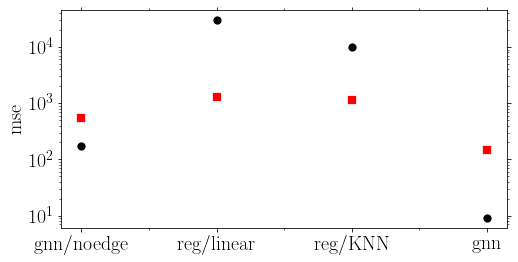

<AxesSubplot:ylabel='$\\mathrm{mse}$'>

In [109]:
# h_train = np.loadtxt('mse/scatter_train_noedge.txt')
# h_test = np.loadtxt('mse/scatter_test_noedge.txt')
# mse_test_noedge = np.mean((h_test[:,0]-h_test[:,1])**2)
# mse_train_noedge = np.mean((h_train[:,0]-h_train[:,1])**2)
# #
# h_train = np.loadtxt('mse/scatter_train_linreg.txt')
# h_test = np.loadtxt('mse/scatter_test_linreg.txt')
# mse_test_linreg = np.mean((h_test[:,0]-h_test[:,1])**2)
# mse_train_linreg = np.mean((h_train[:,0]-h_train[:,1])**2)
# #
# h_train = np.loadtxt('mse/scatter_train_knn.txt')
# h_test = np.loadtxt('mse/scatter_test_knn.txt')
# mse_test_knn = np.mean((h_test[:,0]-h_test[:,1])**2)
# mse_train_knn = np.mean((h_train[:,0]-h_train[:,1])**2)
# #
# h_train = np.loadtxt('mse/scatter_train.txt')
# h_test = np.loadtxt('mse/scatter_test.txt')
# mse_test = np.mean((h_test[:,0]-h_test[:,1])**2)
# mse_train = np.mean((h_train[:,0]-h_train[:,1])**2)

#gnn
mse_test = (np.array(target_nodes_np)[test_mask_np]-np.array(best_output)[test_mask_np]).flatten()
mse_test = np.mean(mse_test*mse_test)
mse_train = (np.array(target_nodes_np)[train_mask_np]-np.array(best_output)[train_mask_np]).flatten()
mse_train = np.mean(mse_train*mse_train)

#gnn no edge
mse_test_no_edge = (np.array(target_nodes_np)[test_mask_np]-np.array(best_output_no_edge)[test_mask_np]).flatten()
mse_test_no_edge = np.mean(mse_test_no_edge*mse_test_no_edge)
mse_train_no_edge = (np.array(target_nodes_np)[train_mask_np]-np.array(best_output_no_edge)[train_mask_np]).flatten()
mse_train_no_edge = np.mean(mse_train_no_edge*mse_train_no_edge)



ax=utl.PltErr([0,1,2,3],[mse_train_no_edge,np.min(mse_train_linreg),np.min(mse_train_knn),mse_train],
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$',fmt='.'),
#            yerr=[0,
#                  0.5*np.quantile(mse_train_linreg,0.95)-np.quantile(mse_train_linreg,0.05),
#                  0.5*np.quantile(mse_train_knn,0.95)-np.quantile(mse_train_knn,0.05),
#                  0
#                 ],
              Plot=False, figsize=(8,4),
          )

utl.PltErr([0,1,2,3],[mse_test_no_edge,np.min(mse_test_linreg),np.min(mse_test_knn),mse_test],
                             attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Train}$',fmt='.'),
#            yerr=[0,
#                  0.5*np.quantile(mse_test_linreg,0.95)-np.quantile(mse_test_linreg,0.05),
#                  0.5*np.quantile(mse_test_knn,0.95)-np.quantile(mse_test_knn,0.05),
#                  0
#                 ],
              xticks=(['$\mathrm{gnn/noedge}$','$\mathrm{reg/linear}$','$\mathrm{reg/KNN}$','$\mathrm{gnn}$'],[0,1,2,3]), 
           ystr='$\mathrm{mse}$',
           ax=ax,
           yscale='log',
           title='png/differentModels.png'
          )
